In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

In [2]:
## Constants
num_neurons = 2000
num_i = int(0.1 * num_neurons)
num_e = int(0.9 * num_neurons)
P = 16
k = 100
novel_inds = torch.arange(0, P // 2)
familiar_inds = torch.arange(P // 2, P)
ie_post = (num_e, num_neurons)
ie_pre = (0, num_e)
ei_post = (0, num_e)
ei_pre = (num_e, num_neurons)
epochs_inner = 10000

In [3]:
# Creates sparse adjacency matrix with the given probability of edge connection and size mxn
def create_adj_matrix(p, m, n):
    # num_connections = int(p * m * n)
    # m_coords = torch.randint(0, m, (num_connections,))
    # n_coords = torch.randint(0, n, (num_connections,))
    # indices = torch.vstack((m_coords, n_coords))
    # values = torch.ones(num_connections)
    # A_mn = torch.sparse_coo_tensor(indices, values, (m, n))
    probs = torch.ones(m, n) * p
    A_mn = torch.bernoulli(probs)
    return A_mn

def compute_initial_recurrent_weights():
    k_ee = k_ei = k_ie = k_ii = k
    #p_ee = k_ee / num_e
    # k inhibitory inputs to that e neuron, out of num_i total inhibitory neurons gives the connection probability per neuron
    p_ei = k_ei / num_i
    p_ie = k_ie / num_e
    #p_ii = k_ii / num_i
    
    # Constants
    #w_ee = 0.1
    w_ei = 0.2
    w_ie = 0.5
    #w_ii = 0.3
    # Ignore ee and ii weights for now:
    p_ee = p_ii = w_ee = w_ii = 0
    with torch.device("cpu"):
        W_ee = create_adj_matrix(p_ee, num_e, num_e) * w_ee
        W_ei = create_adj_matrix(p_ei, num_e, num_i) * -w_ei
        W_ie = create_adj_matrix(p_ie, num_i, num_e) * w_ie
        W_ii = create_adj_matrix(p_ii, num_i, num_i) * -w_ii
        
        # Concat
        W_1 = torch.cat(tensors=(W_ee, W_ei), dim=1)
        W_2 = torch.cat(tensors=(W_ie, W_ii), dim=1)
        W_rec = torch.cat(tensors=(W_1, W_2), dim=0)
    
    return W_rec

In [4]:
## Util functions
def get_update_inds(post, pre, W):
    weights_slice = W[post[0]:post[1], pre[0]:pre[1]]
    inds = torch.nonzero(weights_slice, as_tuple=True)
    update_inds = (inds[0] + post[0], inds[1] + pre[0])
    
    return update_inds

# Sparsity per odor, across all (E) neurons
def sparsity_per_odor(R):
    # Epsilon for if we have zero responses
    eps = 1e-6
    sp_per_odor = 1 - ((torch.sum(R[:num_e], dim=0) ** 2 + eps) / (num_e * (torch.sum(R[:num_e] ** 2, dim=0)) + eps))
    # Sparsity nan means that the responses were all 0 for an odor, meaning that its max sparsity of 1
    return sp_per_odor

# Sparsity per (E) neuron, across a given odor family
def sparsity_per_neuron(R, odor_inds):
    sp_per_neuron = 1 - (
                (torch.sum(R[:num_e, odor_inds], dim=1) ** 2) / ((P // 2) * torch.sum(R[:num_e, odor_inds] ** 2, dim=1)))
    return sp_per_neuron

In [5]:
def plot_corrs(fig, ax, ie_path, ei_path):
   ie_corrs = torch.load(f"{ie_path}/corrs.pt")
   ei_corrs = torch.load(f"{ei_path}/corrs.pt")

   ax[0].plot(torch.arange(epochs_inner), ie_corrs)
   ax[0].set_xlabel("Epochs")
   ax[0].set_ylabel("Average correlation")
   ie_bottom, ie_top = ax[0].get_ylim()
   ax[0].set_ylim(bottom=0)
   ax[0].set_title(f"E->I")

   ax[1].plot(torch.arange(epochs_inner), ei_corrs)
   ax[1].set_xlabel("Epochs")
   ax[1].set_ylabel("Average correlation")
   ei_bottom, ei_top = ax[0].get_ylim()
   ax[1].set_ylim(bottom=0.)
   ax[1].set_title(f"I->E")

   return (ie_bottom, ie_top), (ei_bottom, ei_top)

In [6]:
# Load data from a given realization
ie_realization = 11
ei_realization = 6
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

realization_type = f"./standard"

# IE
ie_path = f"{realization_type}/ie/realization_{ie_realization}/data"
W_ie_initial = torch.load(f"{ie_path}/W_initial.pt").detach().cpu()
W_ie_trained = torch.load(f"{ie_path}/W_trained.pt").detach().cpu()
ie_update_inds = get_update_inds(ie_post, ie_pre, W_ie_trained)
R_ie_initial = torch.load(f"{ie_path}/R_initial.pt").detach().cpu()
R_ie_trained = torch.load(f"{ie_path}/R_trained.pt").detach().cpu()

# EI
ei_path = f"{realization_type}/ei/realization_{ei_realization}/data"
W_ei_initial = torch.load(f"{ei_path}/W_initial.pt").detach().cpu()
W_ei_trained = torch.load(f"{ei_path}/W_trained.pt").detach().cpu()
ei_update_inds = get_update_inds(ei_post, ei_pre, W_ei_trained)
R_initial = torch.load(f"{ei_path}/R_initial.pt").detach().cpu()
R_trained = torch.load(f"{ei_path}/R_trained.pt").detach().cpu()

# Summary Statistics

## Training Variability Across Realizations
1) No Regularization
2) Fix mitral activity, vary recurrent weight initialization
3) Vary mitral activity, fix recurrent weight initialization
4) Sparsity regularization (only E->I)

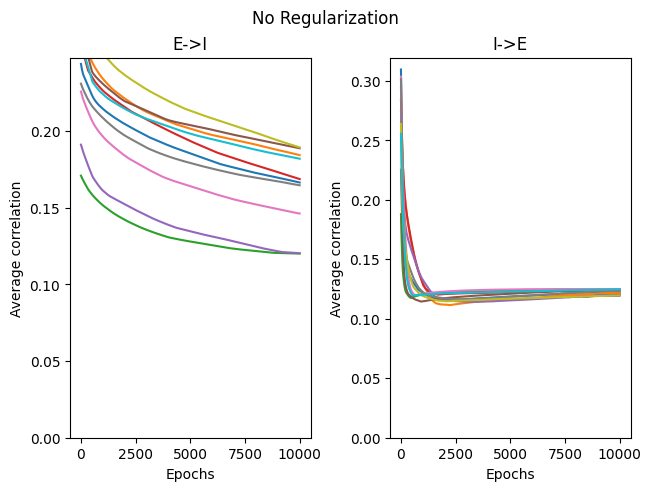

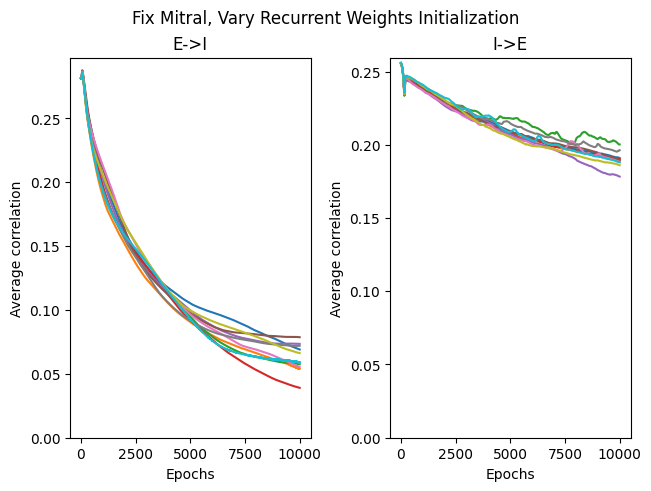

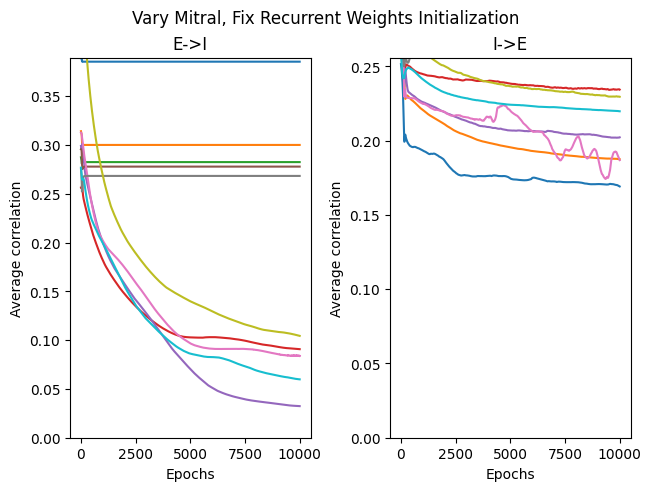

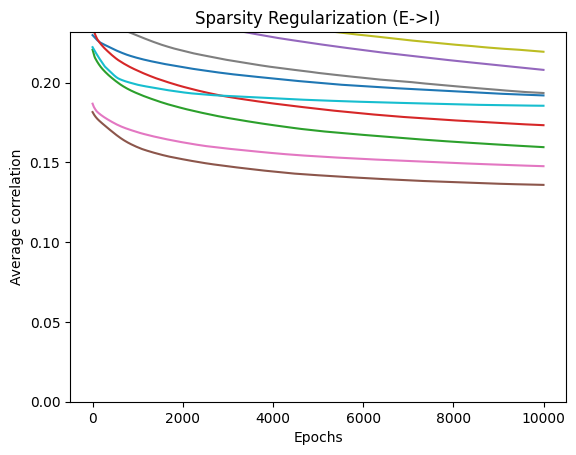

In [7]:
fig_std, ax_std = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
realization_type = f"./standard"
for i in range(10):
    ie_path = f"{realization_type}/ie/realization_{i}/data"
    ei_path = f"{realization_type}/ei/realization_{i}/data"
    _, _ = plot_corrs(fig_std, ax_std, ie_path, ei_path)
fig_std.suptitle("No Regularization")
plt.show()    

fig_fix, ax_fix = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
realization_type = f"./fix_mitral"
for i in range(10):
    ie_path = f"{realization_type}/ie/realization_{i}/data"
    ei_path = f"{realization_type}/ei/realization_{i}/data"
    _, _ = plot_corrs(fig_fix, ax_fix, ie_path, ei_path)
fig_fix.suptitle("Fix Mitral, Vary Recurrent Weights Initialization")
plt.show()

fig_vary, ax_vary = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
realization_type = f"./vary_mitral"
for i in range(10):
    ie_path = f"{realization_type}/ie/realization_{i}/data"
    ei_path = f"{realization_type}/ei/realization_{i}/data"
    _, _ = plot_corrs(fig_vary, ax_vary, ie_path, ei_path)
fig_vary.suptitle("Vary Mitral, Fix Recurrent Weights Initialization")
plt.show()

realization_type = f"./sp_reg"
for i in range(10):
    ie_path = f"{realization_type}/ie/realization_{i}/data"
    ie_corrs = torch.load(f"{ie_path}/corrs.pt")
    plt.plot(torch.arange(epochs_inner), ie_corrs)
    plt.xlabel("Epochs")
    plt.ylabel("Average correlation")
    plt.ylim(bottom=0.)

plt.title("Sparsity Regularization (E->I)")
plt.show()

    

### Training Variability for More Odors

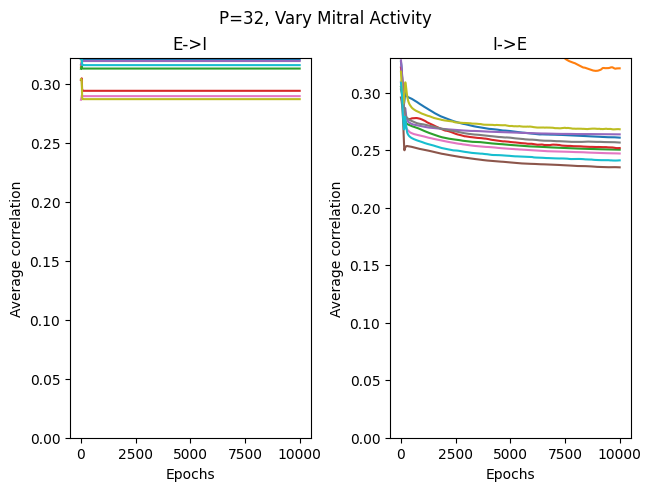

In [8]:
fig_32, ax_32 = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
realization_type = f"./more_odors"
for i in range(10):
    ie_path = f"{realization_type}/ie/realization_{i}/data"
    ei_path = f"{realization_type}/ei/realization_{i}/data"
    (ie_bottom, ie_top), (ei_bottom, ei_top) = plot_corrs(fig_32, ax_32, ie_path, ei_path)
    #ax_32[0].set_ylim((ie_bottom, ie_top))
    #ax_32[1].set_ylim((ei_bottom, ei_top))
fig_32.suptitle("P=32, Vary Mitral Activity")
plt.show()

## Odor Correlation

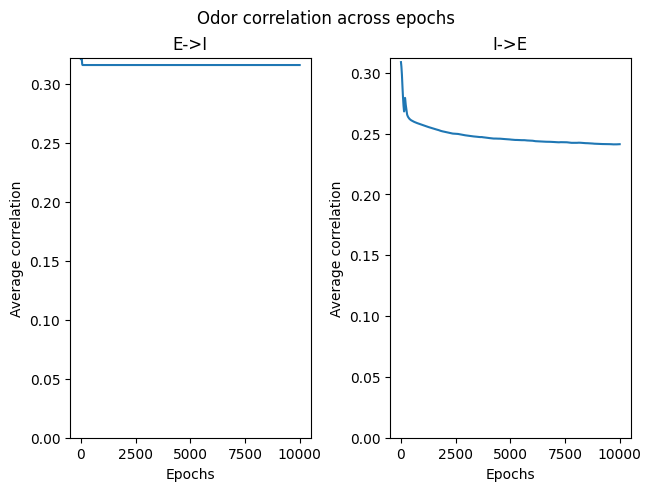

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
plot_corrs(fig, ax, ie_path, ei_path)
fig.suptitle("Odor correlation across epochs")

plt.show()

## Coding Level

In [10]:
# Coding level for the excitatory neurons for each odor
def generate_response_plots(R):
    rows, cols = 4, 4
    size=10
    fig, ax = plt.subplots(nrows=rows, ncols=cols, constrained_layout=True, figsize=(size, size), sharey=True)
    for i in range(rows):
        for j in range(cols):
            #R_plot = R[:num_e, i*rows + j][torch.nonzero(R[:num_e, i*rows + j], as_tuple=True)]
            R_plot = R[:num_e, i*cols + j]
            ax[i, j].hist(R_plot, bins=50, histtype="step", cumulative=True)
            coding_level = torch.count_nonzero(R[:num_e, i*cols + j]).item() / num_e
            ax[i, j].text(0.2, 0.5, f"Coding level: {coding_level:.3f}", fontsize=10, transform=ax[i, j].transAxes)
            ax[i, j].set_title(f"Odor {i*cols + j}")

    return fig

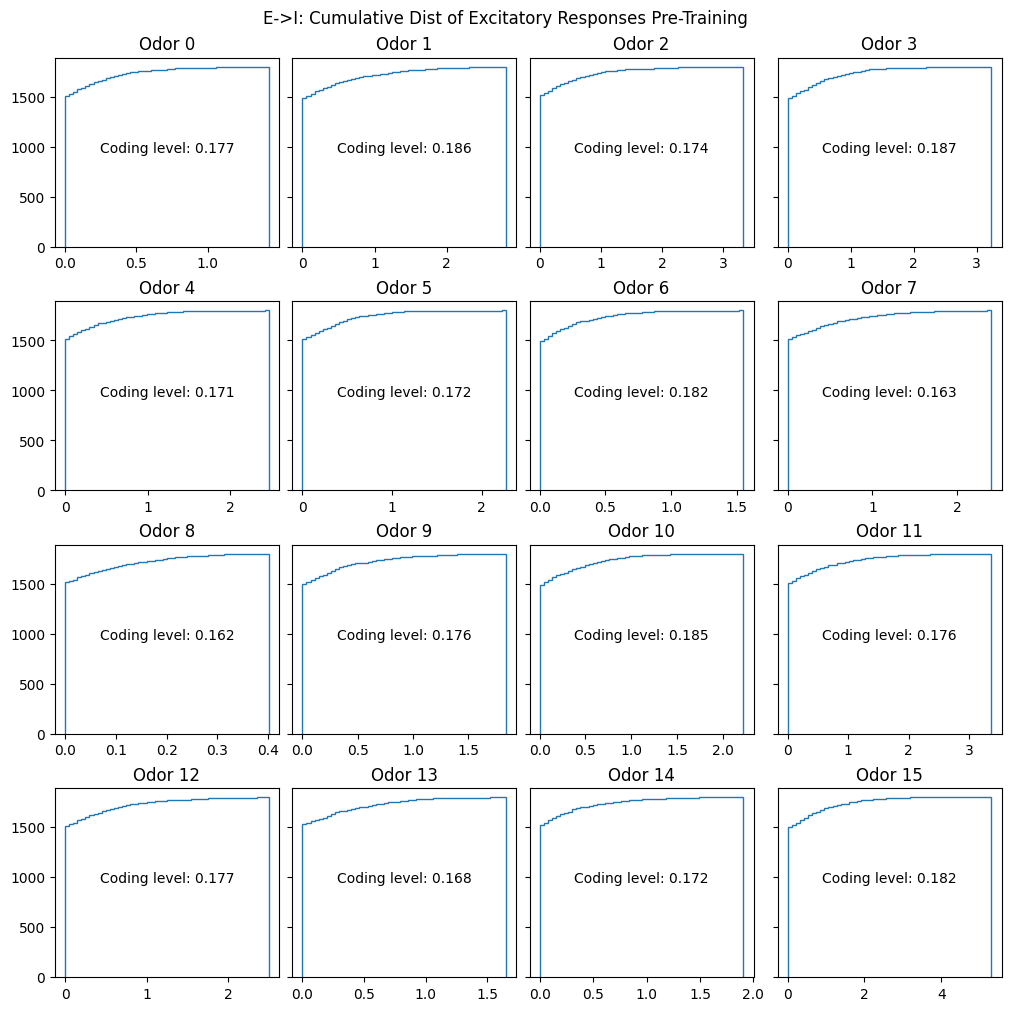

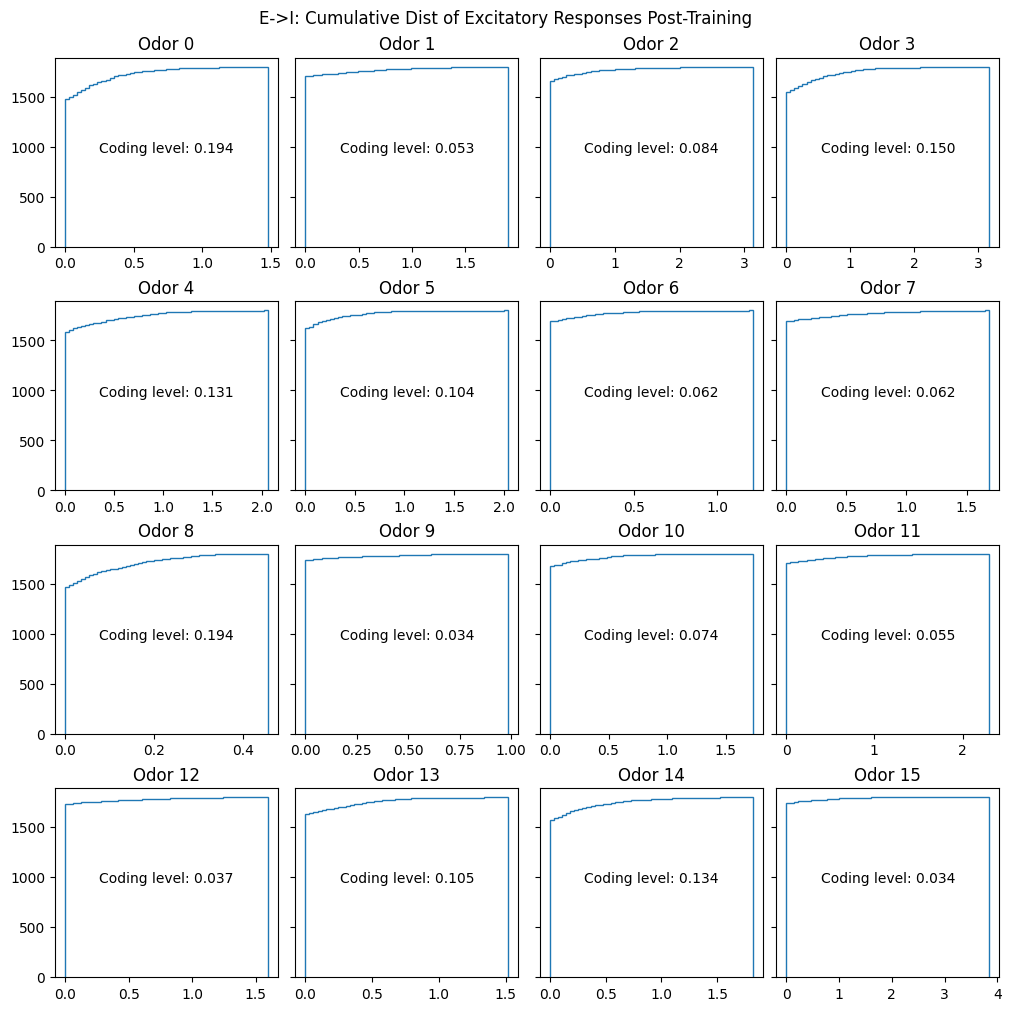

In [11]:
fig = generate_response_plots(R_ie_initial.detach().cpu())
fig.suptitle("E->I: Cumulative Dist of Excitatory Responses Pre-Training")
plt.show()

fig = generate_response_plots(R_ie_trained.detach().cpu())
fig.suptitle("E->I: Cumulative Dist of Excitatory Responses Post-Training")
plt.show()

# fig = generate_response_plots(R_ei_trained.detach().cpu())
# fig.suptitle("I->E: Cumulative Dist of Excitatory Responses Post-Training")
# plt.show()

## Neuron Degree

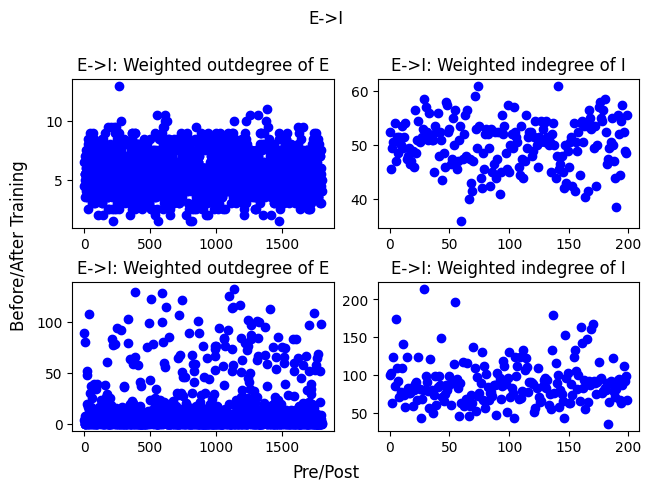

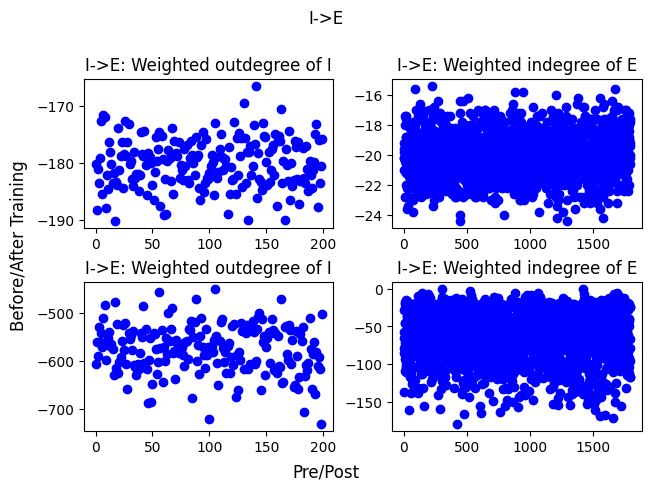

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)

# IE

W0_ie = W_ie_initial[num_e:, :num_e].detach().cpu()
ax[0, 0].plot(torch.sum(W0_ie, dim=0), "bo")
ax[0, 0].set_title("E->I: Weighted outdegree of E")
ax[0, 1].plot(torch.sum(W0_ie, dim=1), "bo")
ax[0, 1].set_title("E->I: Weighted indegree of I")
Wf_ie = W_ie_trained[num_e:, :num_e].detach().cpu()
ax[1, 0].plot(torch.sum(Wf_ie, dim=0), "bo")
ax[1, 0].set_title("E->I: Weighted outdegree of E")
ax[1, 1].plot(torch.sum(Wf_ie, dim=1), "bo")
ax[1, 1].set_title("E->I: Weighted indegree of I")

fig.supylabel("Before/After Training")
fig.supxlabel("Pre/Post")
fig.suptitle("E->I\n")

plt.show()

# EI

fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
W0_ei = W_ei_initial[:num_e, num_e:].detach().cpu()
ax[0, 0].plot(torch.sum(W0_ei, dim=0), "bo")
ax[0, 0].set_title("I->E: Weighted outdegree of I")
ax[0, 1].plot(torch.sum(W0_ei, dim=1), "bo")
ax[0, 1].set_title("I->E: Weighted indegree of E")
Wf_ei = W_ei_trained[:num_e, num_e:].detach().cpu()
ax[1, 0].plot(torch.sum(Wf_ei, dim=0), "bo")
ax[1, 0].set_title("I->E: Weighted outdegree of I")
ax[1, 1].plot(torch.sum(Wf_ei, dim=1), "bo")
ax[1, 1].set_title("I->E: Weighted indegree of E")

fig.supylabel("Before/After Training")
fig.supxlabel("Pre/Post")
fig.suptitle("I->E\n")

plt.show()

# print(f"E->I: Nonzero excitatory neurons: {torch.count_nonzero(torch.sum(torch.abs(W_ie), dim=0) > 1e-0)} out of {num_e}")
# print(f"E->I: Nonzero inhibitory neurons: {torch.count_nonzero(torch.sum(torch.abs(W_ie), dim=1) > 1e-0)} out of {num_i}")
# print()
# print(f"I->E: Nonzero inhibitory neurons: {torch.count_nonzero(torch.sum(torch.abs(W_ei), dim=0) > 1e-0)} out of {num_i}")
# print(f"I->E: Nonzero excitatory neurons: {torch.count_nonzero(torch.sum(torch.abs(W_ei), dim=1) > 1e-0)} out of {num_e}")

### Sparsities (Non-Regularized)

In [13]:
def generate_spars_plot(fig, ax, sp_novel, sp_familiar, is_ei, is_trained):
    start = 0.5
    space = 1
    width = space / 2
    coords = [start, start+space]
    spread = (torch.rand(size=(P // 2,)) - 0.5) * width

    if is_ei is not None:
        ax[is_ei, is_trained].scatter(spread + coords[0], sp_novel, label="Novel")
        ax[is_ei, is_trained].scatter(spread + coords[1], sp_familiar, label="Familiar")
        ax[is_ei, is_trained].set_xticks(ticks=coords, labels=[])
        ax[is_ei, is_trained].set_xlim(left=coords[0]-(1.5*width), right=coords[1]+(1.5*width))
        ax[is_ei, is_trained].set_ylim(0, 1)
        ax[is_ei, is_trained].bar(coords, [torch.mean(sp_novel), torch.mean(sp_familiar)], width = width/2, alpha=0.5, color="green")
        ax[is_ei, is_trained].legend(loc="lower left")
    else:
        ax[is_trained].scatter(spread + coords[0], sp_novel, label="Novel")
        ax[is_trained].scatter(spread + coords[1], sp_familiar, label="Familiar")
        ax[is_trained].set_xticks(ticks=coords, labels=[])
        ax[is_trained].set_xlim(left=coords[0]-(1.5*width), right=coords[1]+(1.5*width))
        ax[is_trained].set_ylim(0, 1)
        ax[is_trained].bar(coords, [torch.mean(sp_novel), torch.mean(sp_familiar)], width = width/2, alpha=0.5, color="green")
        ax[is_trained].legend(loc="lower left")

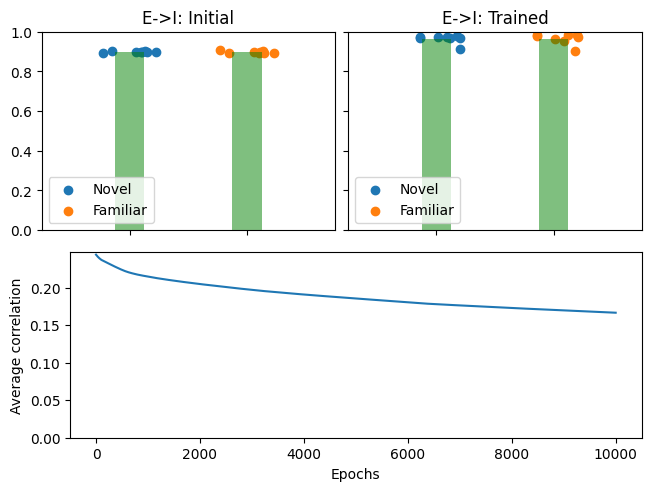

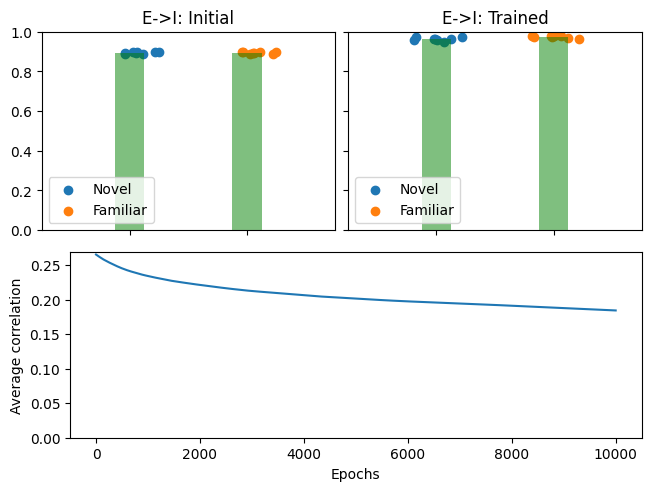

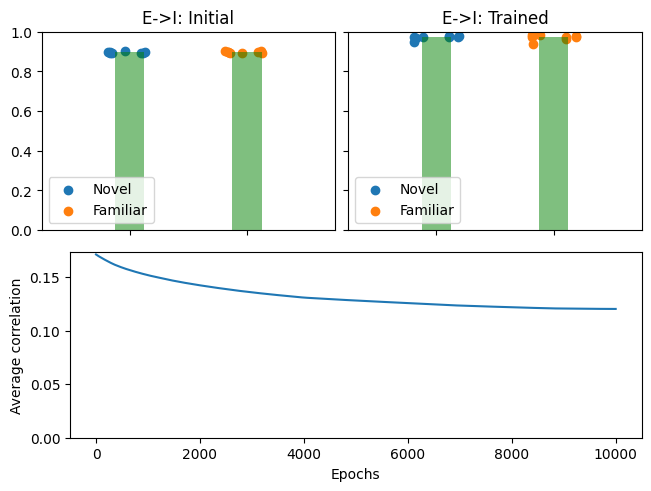

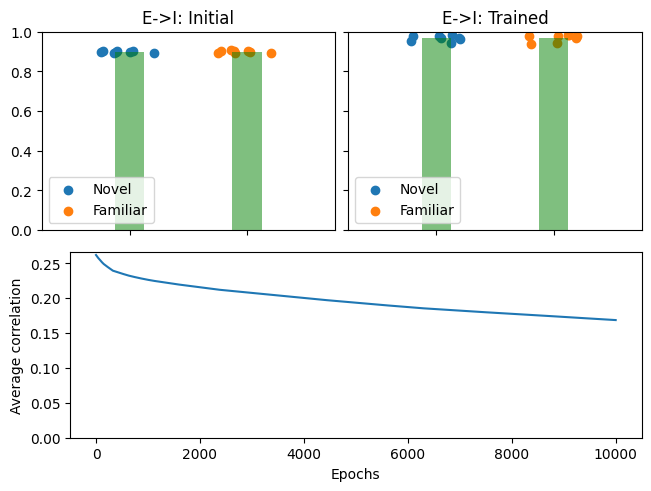

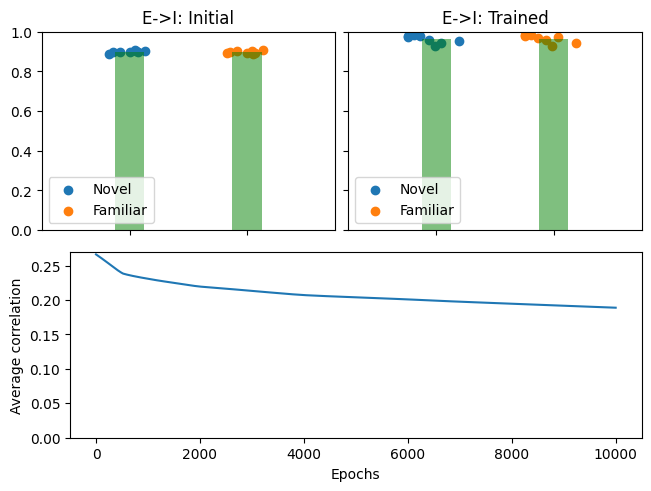

In [14]:
reals = [0, 1, 2, 3, 5]
for r in reals:
    ie_path = f"./standard/ie/realization_{r}/data"
    R_ie_initial = torch.load(f"{ie_path}/R_initial.pt")
    R_ie_trained = torch.load(f"{ie_path}/R_trained.pt")
    sp_ie_corrs = torch.load(f"{ie_path}/corrs.pt")

    mainfig = plt.figure(layout='constrained') #figsize=(10, 4)
    subfigs = mainfig.subfigures(nrows=2, ncols=1, wspace=0.07)
    ax = subfigs[0].subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    # Novel, familiar

    ei_sp_odor_initial = sparsity_per_odor(R_ie_initial).detach().cpu()
    ie_sp_odor_trained = sparsity_per_odor(R_ie_trained).detach().cpu()
    ie_sp_novel_0 = ei_sp_odor_initial[novel_inds]
    ie_sp_familiar_0 = ei_sp_odor_initial[familiar_inds]
    ie_sp_novel_f = ie_sp_odor_trained[novel_inds]
    ie_sp_familiar_f = ie_sp_odor_trained[familiar_inds]
    generate_spars_plot(fig, ax, ie_sp_novel_0, ie_sp_familiar_0, None, 0)
    ax[0].set_title("E->I: Initial")
    generate_spars_plot(fig, ax, ie_sp_novel_f, ie_sp_familiar_f, None, 1)
    ax[1].set_title("E->I: Trained")

    bottom_ax = subfigs[1].subplots(1)
    bottom_ax.plot(torch.arange(epochs_inner), sp_ie_corrs)
    bottom_ax.set_xlabel("Epochs")
    bottom_ax.set_ylabel("Average correlation")
    bottom_ax.set_ylim(bottom=0.)

    #fig.suptitle("Sparsity Per Odor: No Regularization")

    plt.show()

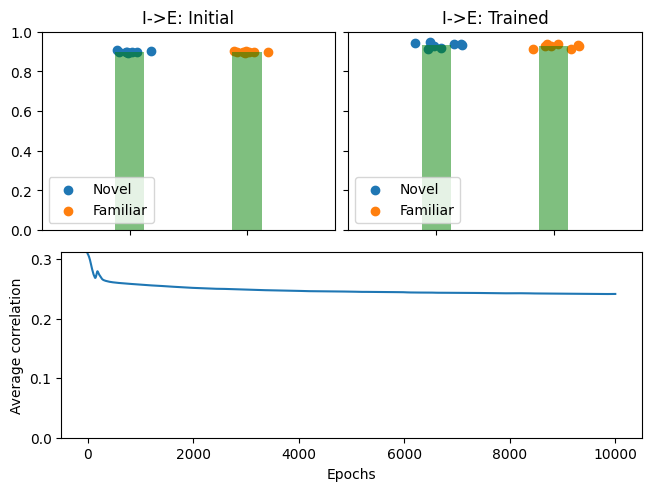

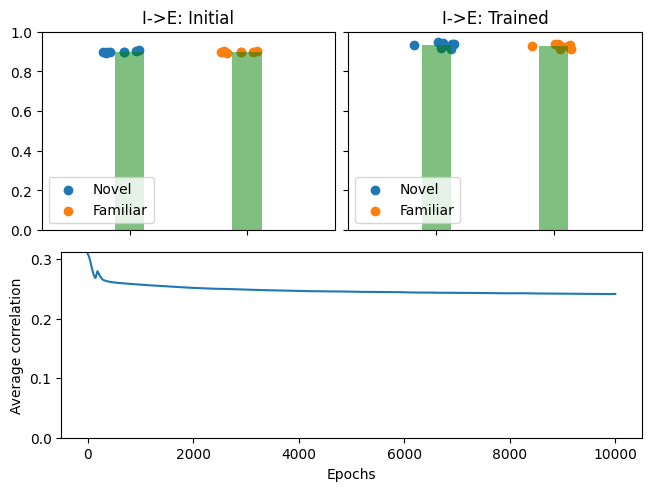

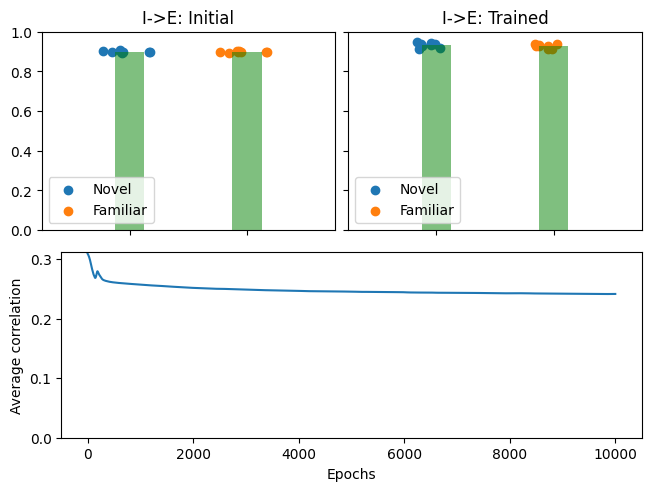

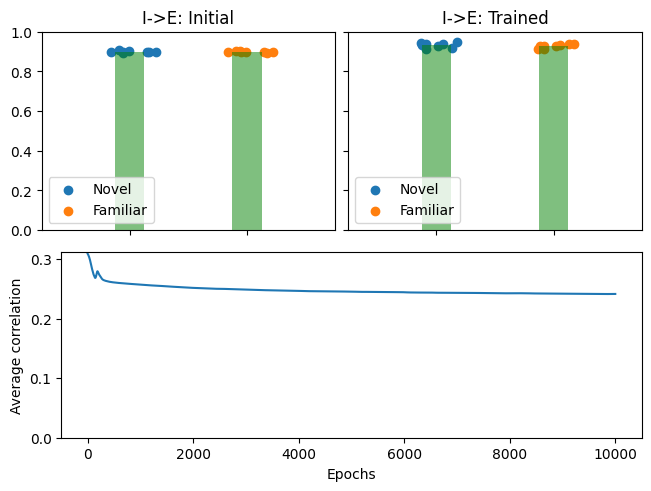

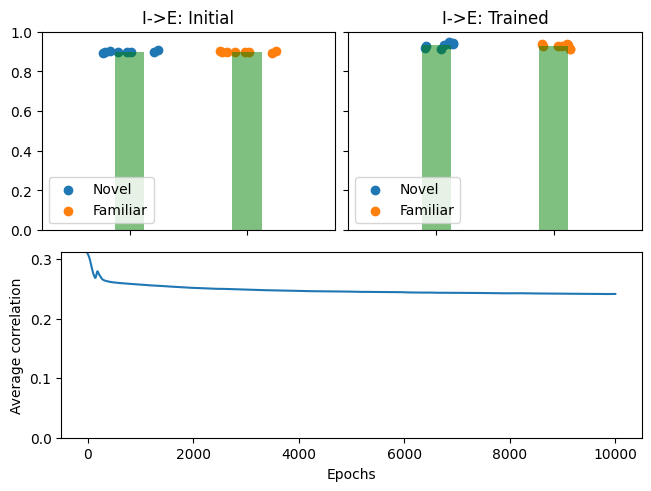

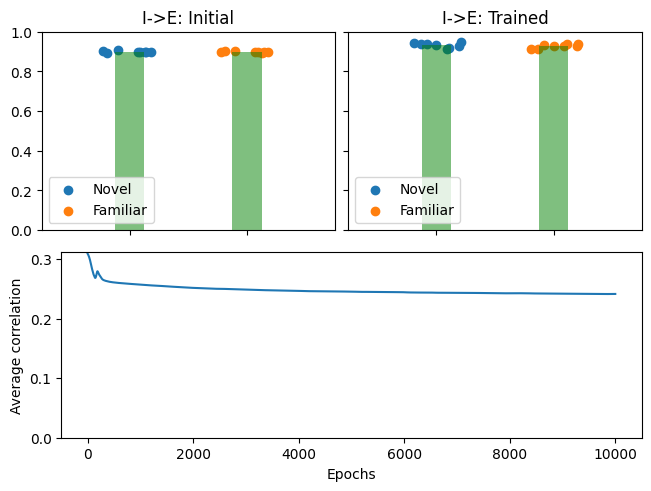

In [15]:
reals = [0, 1, 2, 3, 4, 5]
for r in reals:
    ie_path = f"./standard/ei/realization_{r}/data"
    R_ie_initial = torch.load(f"{ei_path}/R_initial.pt")
    R_ie_trained = torch.load(f"{ei_path}/R_trained.pt")
    sp_ie_corrs = torch.load(f"{ei_path}/corrs.pt")

    mainfig = plt.figure(layout='constrained') #figsize=(10, 4)
    subfigs = mainfig.subfigures(nrows=2, ncols=1, wspace=0.07)
    ax = subfigs[0].subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    # Novel, familiar

    ei_sp_odor_initial = sparsity_per_odor(R_initial).detach().cpu()
    ei_sp_odor_trained = sparsity_per_odor(R_trained).detach().cpu()
    ei_sp_novel_0 = ei_sp_odor_initial[novel_inds]
    ei_sp_familiar_0 = ei_sp_odor_initial[familiar_inds]
    ei_sp_novel_f = ei_sp_odor_trained[novel_inds]
    ei_sp_familiar_f = ei_sp_odor_trained[familiar_inds]
    generate_spars_plot(fig, ax, ei_sp_novel_0, ei_sp_familiar_0, None, 0)
    ax[0].set_title("I->E: Initial")
    generate_spars_plot(fig, ax, ei_sp_novel_f, ei_sp_familiar_f, None, 1)
    ax[1].set_title("I->E: Trained")

    bottom_ax = subfigs[1].subplots(1)
    bottom_ax.plot(torch.arange(epochs_inner), sp_ie_corrs)
    bottom_ax.set_xlabel("Epochs")
    bottom_ax.set_ylabel("Average correlation")
    bottom_ax.set_ylim(bottom=0.)

    fig.suptitle("Sparsity Per Odor: No Regularization")

    plt.show()

## Sparsity Regularization

In [16]:
# realization_type = f"./sp_reg"
# fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, constrained_layout=True)
# for i in range(10):
#     ie_path = f"{realization_type}/ie/realization_{i}/data"
#     ie_corrs = torch.load(f"{ie_path}/corrs.pt")
#     ie_spars = torch.load(f"{ie_path}/spars.pt")
#     x, y = i // 2, i % 2
#     ax[x, y].plot(torch.arange(epochs_inner), ie_corrs, label="Odor Correlation")
#     ax[x, y].plot(torch.arange(epochs_inner), ie_spars, label="Sparsity Difference")
#     #ax[x, y].set_xlabel("Epochs")
#     #ax[x, y].set_ylabel("Value")
#     ax[x, y].set_ylim(bottom=0.)

# fig.suptitle("E->I Sparsity Regularization: Correlation vs Sparsity")
# fig.supxlabel("Epochs")
# plt.show()

### Sparsity Regularization

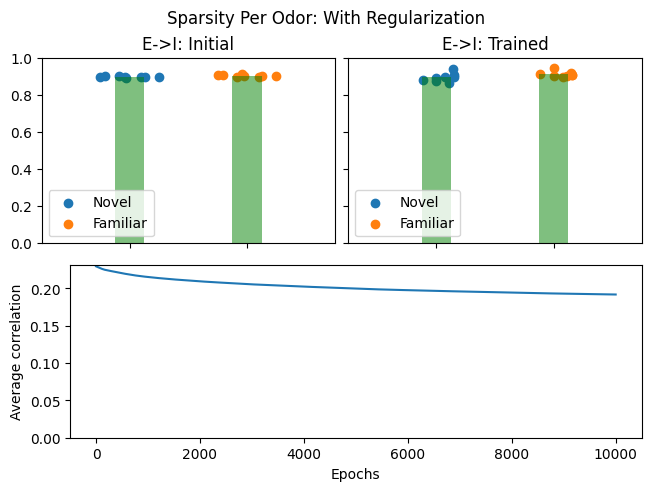

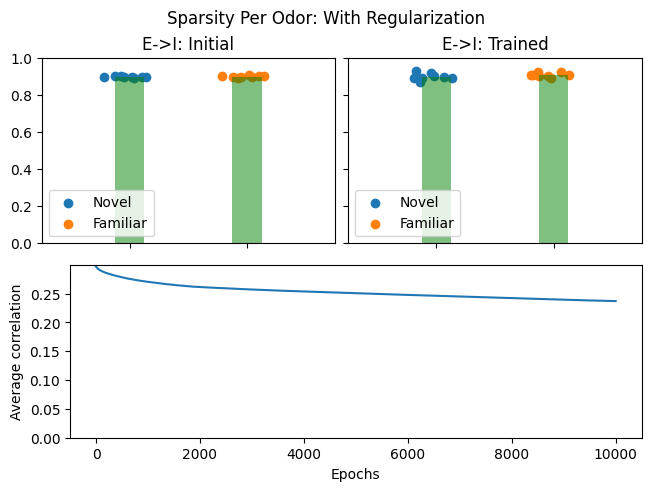

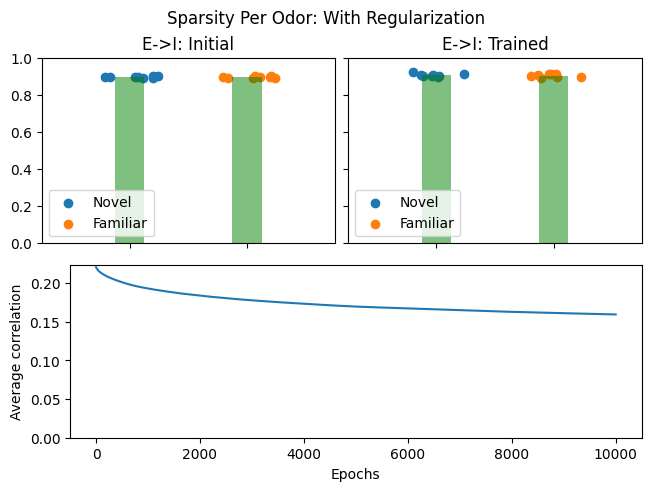

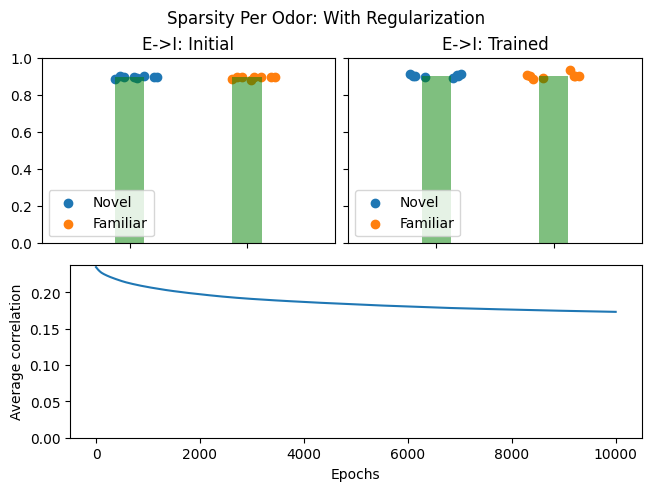

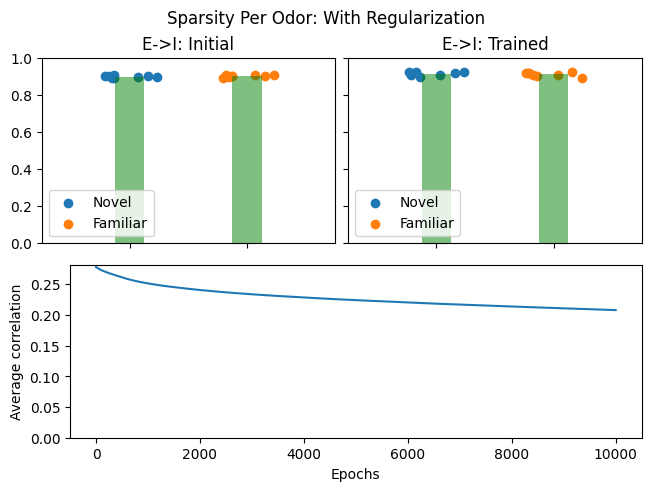

In [17]:
for r in range(5):
    # IE
    ie_path = f"./sp_reg/ie/realization_{r}/data"
    R_sp_ie_initial = torch.load(f"{ie_path}/R_initial.pt")
    R_sp_ie_trained = torch.load(f"{ie_path}/R_trained.pt")
    sp_ie_corrs = torch.load(f"{ie_path}/corrs.pt")
    
    mainfig = plt.figure(layout='constrained') #figsize=(10, 4)
    subfigs = mainfig.subfigures(nrows=2, ncols=1, wspace=0.07)
    ax = subfigs[0].subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    # Novel, familiar

    ei_sp_odor_initial = sparsity_per_odor(R_sp_ie_initial).detach().cpu()
    ie_sp_odor_trained = sparsity_per_odor(R_sp_ie_trained).detach().cpu()
    ie_sp_novel_0 = ei_sp_odor_initial[novel_inds]
    ie_sp_familiar_0 = ei_sp_odor_initial[familiar_inds]
    ie_sp_novel_f = ie_sp_odor_trained[novel_inds]
    ie_sp_familiar_f = ie_sp_odor_trained[familiar_inds]
    generate_spars_plot(fig, ax, ie_sp_novel_0, ie_sp_familiar_0, None, 0)
    ax[0].set_title("E->I: Initial")
    generate_spars_plot(fig, ax, ie_sp_novel_f, ie_sp_familiar_f, None, 1)
    ax[1].set_title("E->I: Trained")

    mainfig.suptitle("Sparsity Per Odor: With Regularization")

    bottom_ax = subfigs[1].subplots(1)
    bottom_ax.plot(torch.arange(epochs_inner), sp_ie_corrs)
    bottom_ax.set_xlabel("Epochs")
    bottom_ax.set_ylabel("Average correlation")
    bottom_ax.set_ylim(bottom=0.)

    plt.show()

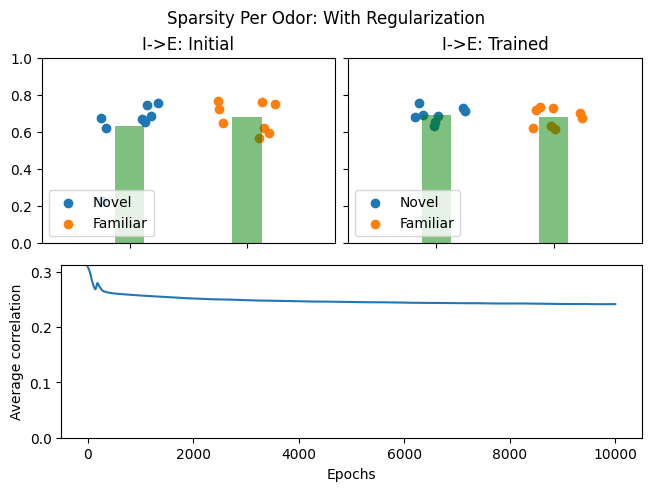

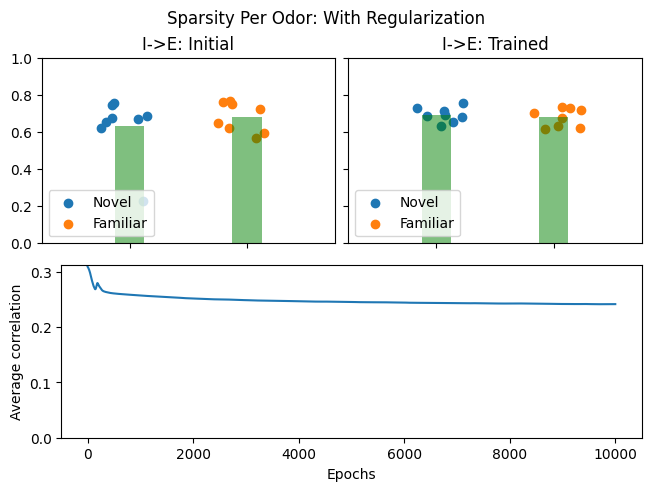

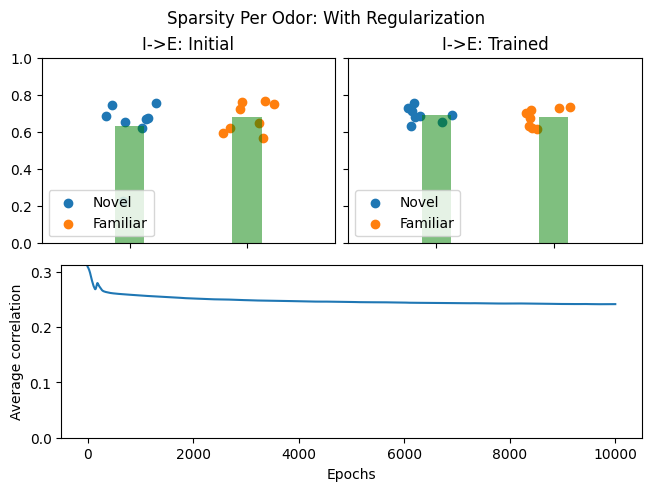

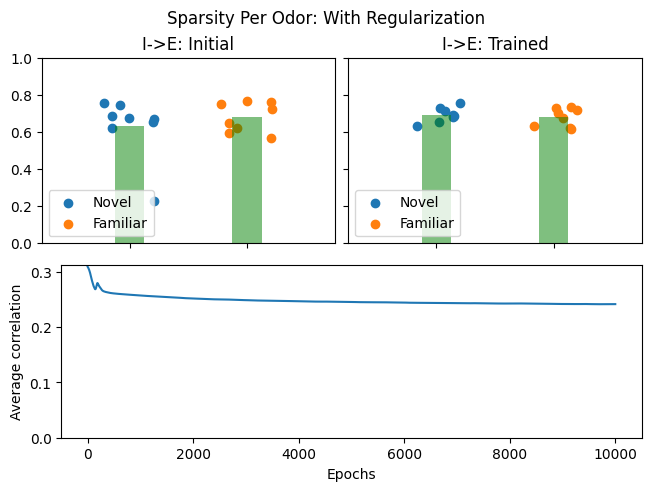

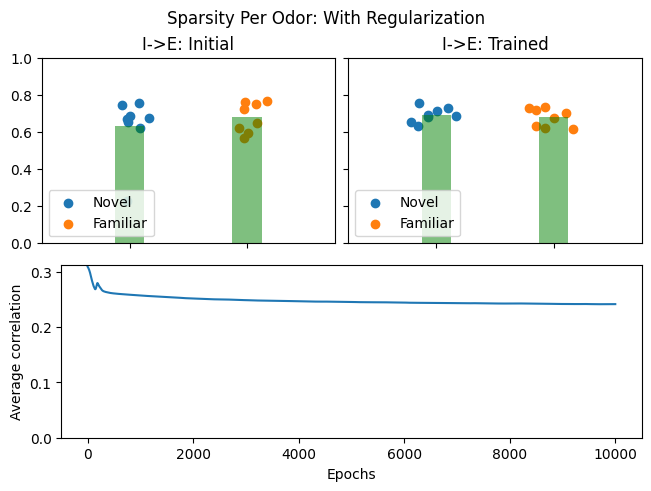

In [18]:
for r in range(5):
    ie_path = f"./sp_reg/ei/realization_{r}/data"
    R_initial = torch.load(f"{ei_path}/R_initial.pt")
    R_trained = torch.load(f"{ei_path}/R_trained.pt")
    sp_ie_corrs = torch.load(f"{ei_path}/corrs.pt")

    mainfig = plt.figure(layout='constrained') #figsize=(10, 4)
    subfigs = mainfig.subfigures(nrows=2, ncols=1, wspace=0.07)
    ax = subfigs[0].subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    # Novel, familiar

    ei_sp_odor_initial = sparsity_per_odor(R_initial).detach().cpu()
    ei_sp_odor_trained = sparsity_per_odor(R_trained).detach().cpu()
    ei_sp_novel_0 = ei_sp_odor_initial[novel_inds]
    ei_sp_familiar_0 = ei_sp_odor_initial[familiar_inds]
    ei_sp_novel_f = ei_sp_odor_trained[novel_inds]
    ei_sp_familiar_f = ei_sp_odor_trained[familiar_inds]
    generate_spars_plot(fig, ax, ei_sp_novel_0, ei_sp_familiar_0, None, 0)
    ax[0].set_title("I->E: Initial")
    generate_spars_plot(fig, ax, ei_sp_novel_f, ei_sp_familiar_f, None, 1)
    ax[1].set_title("I->E: Trained")

    bottom_ax = subfigs[1].subplots(1)
    bottom_ax.plot(torch.arange(epochs_inner), sp_ie_corrs)
    bottom_ax.set_xlabel("Epochs")
    bottom_ax.set_ylabel("Average correlation")
    bottom_ax.set_ylim(bottom=0.)

    plt.suptitle("Sparsity Per Odor: With Regularization")

    plt.show()

### Novel Odor Correlations (Sparsity Regularization)

In [65]:
def odor_corrs(R, family_inds):
    R_adjusted = R[:num_e, family_inds] - torch.mean(R[:num_e, family_inds], dim=1, keepdim=True)
    R_adjusted.t_()
    sigma_E = torch.corrcoef(R_adjusted) -  torch.eye(P // 2)

    avg_corr = torch.mean(torch.abs(sigma_E))

    return avg_corr, sigma_E

def odor_family_corrs(path):
    sz=2.5
    rows, cols = 2, 5
    fig = plt.figure(figsize=(cols*sz, rows*sz))
    ax = fig.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    for r in range(rows*cols):
        R_initial = torch.load(f"{path}/realization_{r}/data/R_initial.pt").detach().cpu()
        R_trained = torch.load(f"{path}/realization_{r}/data/R_trained.pt").detach().cpu()
        avg_familiar0, _ = odor_corrs(R_initial, familiar_inds)
        avg_familiarf, _ = odor_corrs(R_trained, familiar_inds)

        avg_novel0, _ = odor_corrs(R_initial, novel_inds)
        avg_novelf, _ = odor_corrs(R_trained, novel_inds)
        
        start = 0.5
        space = 1
        width = space / 2
        coords = torch.Tensor([start, start+2*space])
        x, y = r // cols, r % cols

        ax[x, y].bar(coords, [avg_novel0, avg_novelf], width=width, label=['Novel', ''])
        ax[x, y].bar(coords+width, [avg_familiar0, avg_familiarf], width=width, label=['Familiar', ''])
        ax[x, y].set_xlim(left=coords[0]-(1.5*width), right=coords[1]+(1.5*width))
        #plt.ylabel("Avg Correlation")
        ax[x, y].set_xticks(ticks=coords+(width/2), labels=["Before", "After"])
        if (x, y) == (0, cols-1):
            ax[x, y].legend()

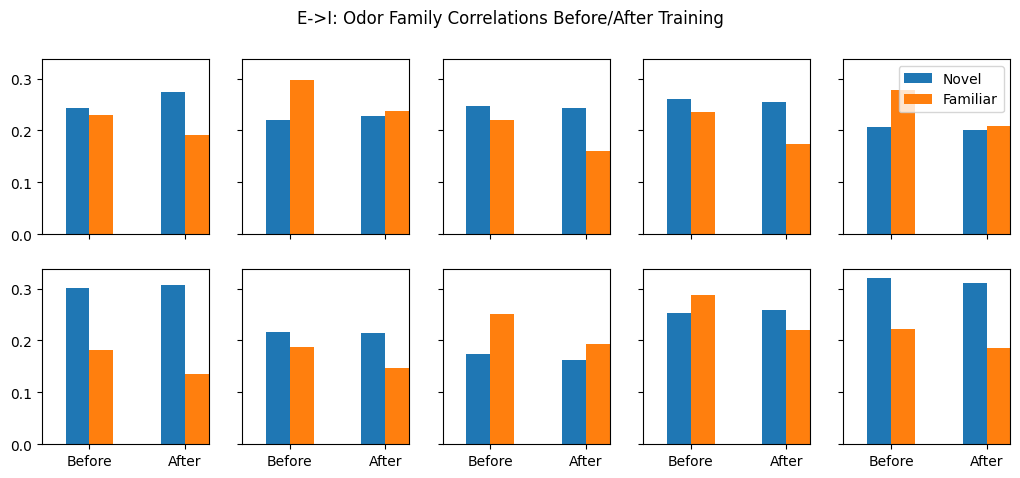

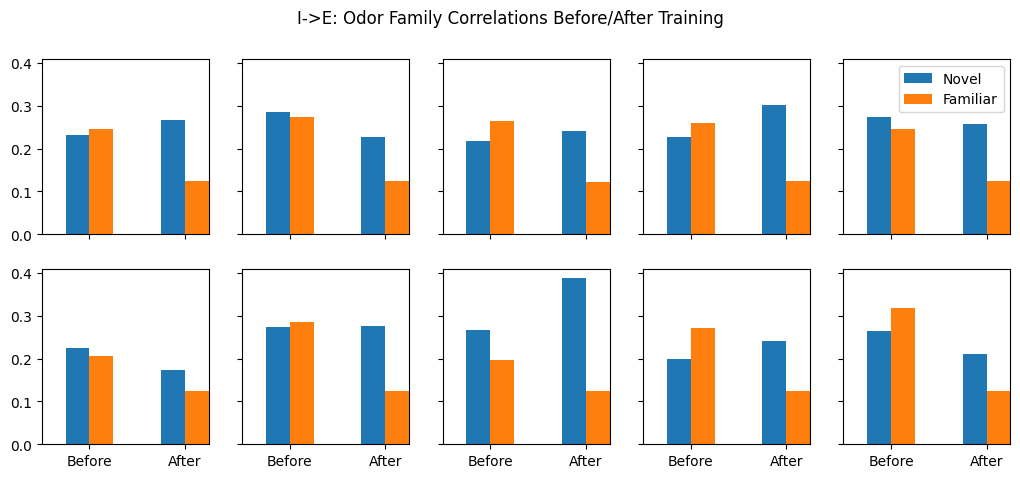

In [66]:
odor_family_corrs("./sp_reg/ie")
plt.suptitle("E->I: Odor Family Correlations Before/After Training")
plt.show()

odor_family_corrs("./sp_reg/ei")
plt.suptitle("I->E: Odor Family Correlations Before/After Training")
plt.show()

# Shows effect is specific to familiar odors

### Correlations Before/After Training

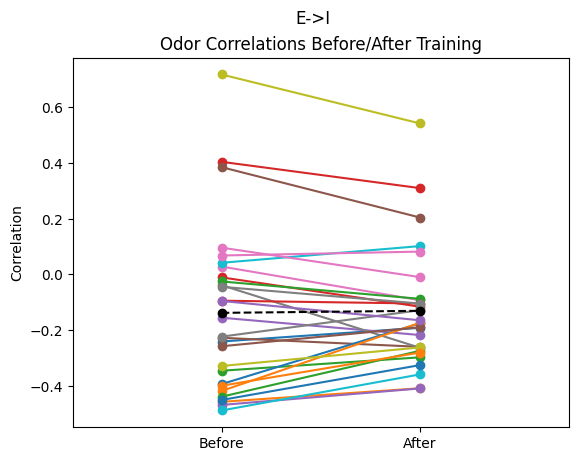

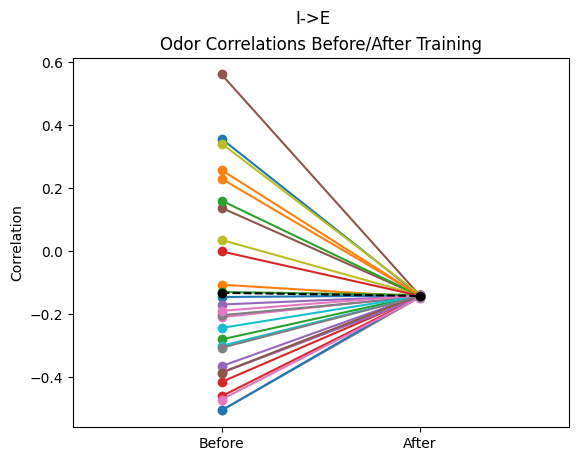

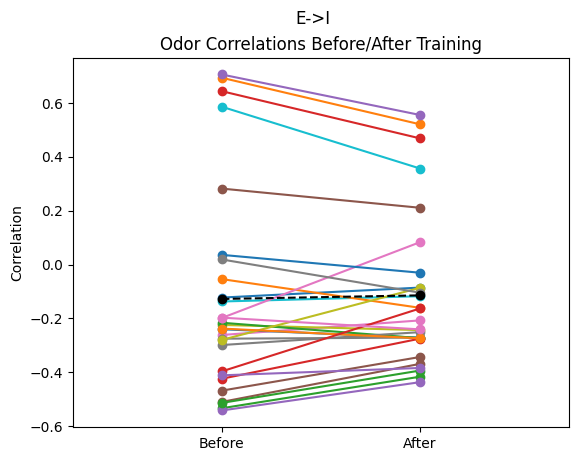

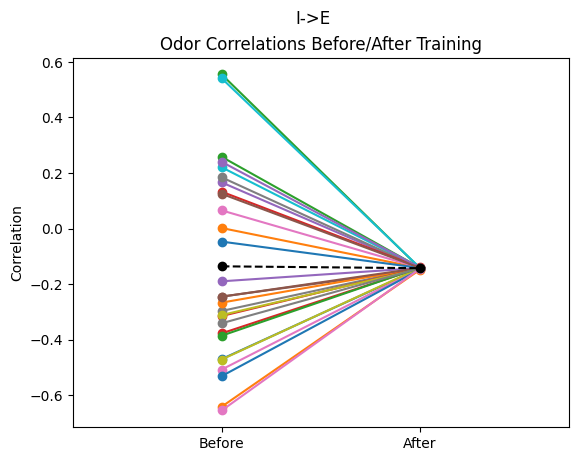

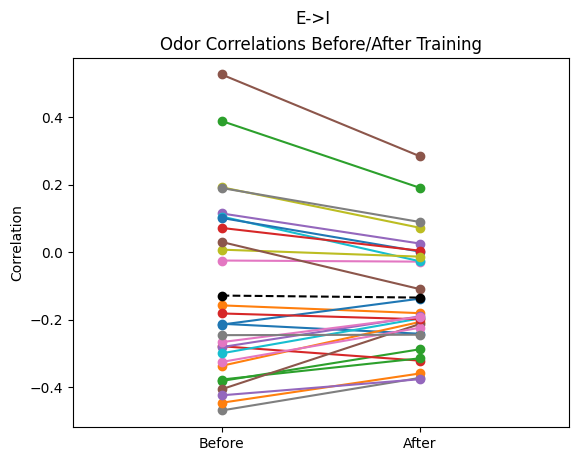

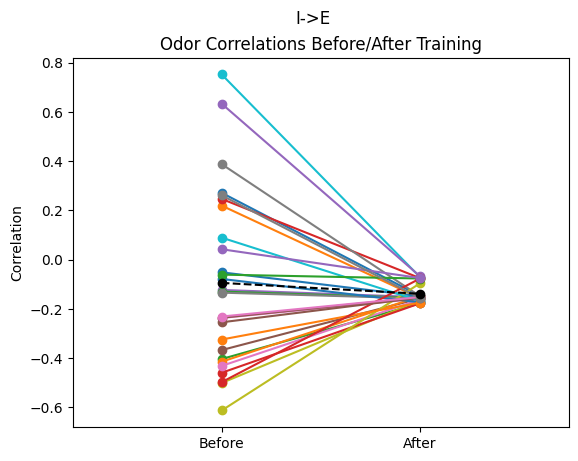

In [67]:
def generate_corr_plot(R_initial, R_trained):
    # Don't plot the diagonals (odor corr w/ itself)
    inds = torch.triu_indices(P // 2, P // 2, 1)
    _, corrs0 = odor_corrs(R_initial.detach().cpu(), familiar_inds)
    corrs0 = corrs0[inds[0], inds[1]]
    _, corrsf = odor_corrs(R_trained.detach().cpu(), familiar_inds)
    corrsf = corrsf[inds[0], inds[1]]

    mean0 = torch.mean(corrs0)
    meanf = torch.mean(corrsf)

    start = 0.5
    space = 1
    width = space / 2
    coords = [start, start+space]

    fig, ax = plt.subplots(1, 1)
    ax.plot(torch.repeat_interleave(torch.Tensor(coords).unsqueeze(0).t(), inds.shape[1], dim=1), torch.vstack((corrs0, corrsf)), marker="o", linestyle="solid")
    ax.plot(coords, [mean0, meanf], marker="o", linestyle="dashed", color="black")
    ax.set_xlim(left=coords[0]-(1.5*width), right=coords[1]+(1.5*width))
    ax.set_title("Odor Correlations Before/After Training")
    ax.set_ylabel("Correlation")
    ax.set_xticks(ticks=coords, labels=["Before", "After"])

for r in range(3):
    R_ie_initial = torch.load(f"./sp_reg/ie/realization_{r}/data/R_initial.pt", map_location='cpu')
    R_ie_trained = torch.load(f"./sp_reg/ie/realization_{r}/data/R_trained.pt", map_location='cpu')

    generate_corr_plot(R_ie_initial, R_ie_trained)
    plt.suptitle("E->I")

    R_ei_initial = torch.load(f"./sp_reg/ei/realization_{r}/data/R_initial.pt", map_location='cpu')
    R_ei_trained = torch.load(f"./sp_reg/ei/realization_{r}/data/R_trained.pt", map_location='cpu')
    generate_corr_plot(R_ei_initial, R_ei_trained)
    plt.suptitle("I->E")

### Neuron Correlations

In [22]:
def neuron_corrs(R, inds):
    sigma_E = torch.corrcoef(R[:, inds])
    
    return sigma_E

def neuron_corr_plot(R_ie_initial, R_ie_trained):
    nonzero_i = torch.nonzero(torch.sum(torch.abs(Wf_ie), dim=1) > 1e-0)[:, 0]
    relevant_i = Wf_ie[nonzero_i, :]
    inds = torch.nonzero(relevant_i, as_tuple=True)
    inds0 = nonzero_i[inds[0]]
    inds1 = inds[1]

    ie_corrs0 = neuron_corrs(R_ie_initial.detach().cpu())[num_e:, :num_e][inds0, inds1]
    ie_corrsf = neuron_corrs(R_ie_trained.detach().cpu())[num_e:, :num_e][inds0, inds1]
    start = 0.5
    space = 1
    width = space / 2
    coords = [start, start+space]

    _, ax = plt.subplots(1, 1)
    ax.plot(torch.repeat_interleave(torch.Tensor(coords).unsqueeze(0).t(), ie_corrs0.shape[0], dim=1), torch.vstack((ie_corrs0, ie_corrsf)), marker="o", linestyle="solid")
    ax.set_xlim(left=coords[0]-(1.5*width), right=coords[1]+(1.5*width))
    ax.set_title("E->I Neuron Correlations Before/After Training")
    ax.set_ylabel("Correlation")
    ax.set_xticks(ticks=coords, labels=["Before", "After"])

    plt.show()

# reals = [10, 12, 13, 14, 16, 19]
# for r in reals:
#     ie_path = f"./standard/ie/realization_{r}/data"
#     R_ie_initial = torch.load(f"{ie_path}/R_initial.pt", map_location='cpu')
#     R_ie_trained = torch.load(f"{ie_path}/R_trained.pt", map_location='cpu')

#     neuron_corr_plot(R_ie_initial, R_ie_trained)

In [75]:
def generate_corr_hist(path, post, pre, odor_family):
    post_len = post[1] - post[0]
    pre_len = pre[1] - pre[0]
    # E-I or I-E, take all indices
    is_triu = False
    # E-E or I-I, then take triu_indices
    if post_len == pre_len:
        inds = torch.triu_indices(post_len, pre_len, 1)
        is_triu = True
        

    sz = 2.5
    rows, cols = 2, 5
    fig = plt.figure(figsize=(cols*sz, rows*sz))
    ax = fig.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    for r in range(rows*cols):
        x, y = r // cols, r % cols

        R_initial = torch.load(f"{path}/realization_{r}/data/R_initial.pt").detach().cpu()
        R_trained = torch.load(f"{path}/realization_{r}/data/R_trained.pt").detach().cpu()

        
        if is_triu:
            corrs0 = neuron_corrs(R_initial, odor_family)[post[0]:post[1], pre[0]:pre[1]][inds[0], inds[1]]
            corrsf = neuron_corrs(R_trained, odor_family)[post[0]:post[1], pre[0]:pre[1]][inds[0], inds[1]]
        else:
            corrs0 = neuron_corrs(R_initial, odor_family)[post[0]:post[1], pre[0]:pre[1]].flatten()
            corrsf = neuron_corrs(R_trained, odor_family)[post[0]:post[1], pre[0]:pre[1]].flatten()

        ax[x, y].hist(corrs0, label="Before", density=True, histtype="step")
        ax[x, y].hist(corrsf, label="After", density=True)
        if x == rows - 1:
            ax[x, y].set_xlabel("Correlation")
        if (x, y) == (0, cols - 1):
            ax[x, y].legend()

Text(0.5, 0.98, 'E-E Neuron Correlations (Across Novel) Before/After I->E Training')

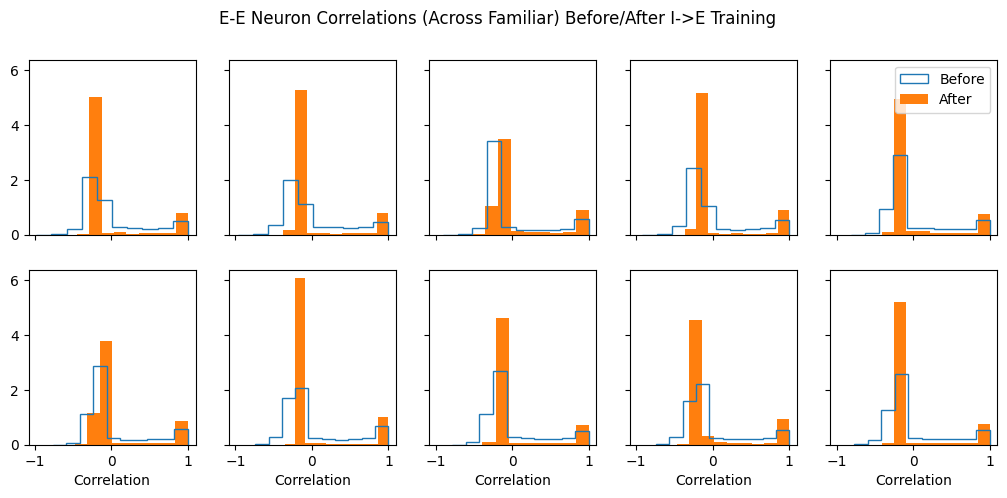

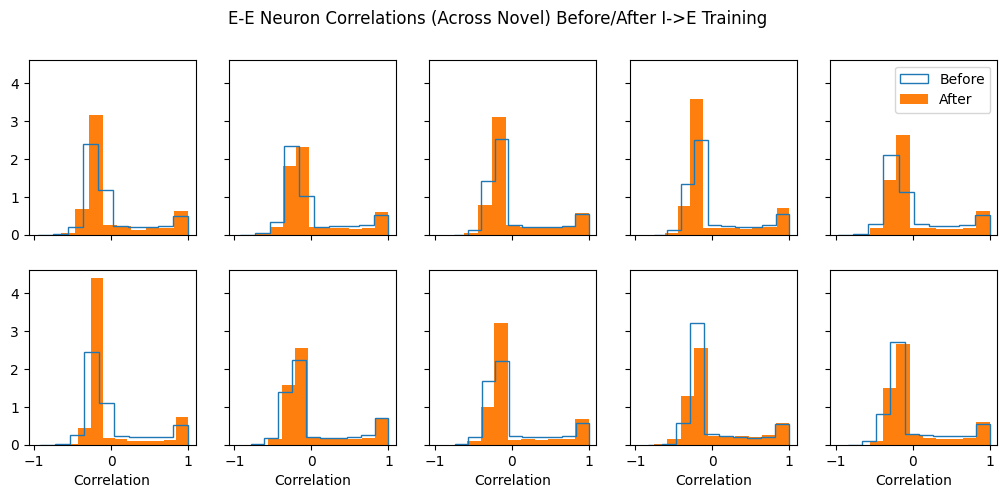

In [76]:
# generate_corr_hist("./sp_reg/ie")
# plt.suptitle("Neuron Correlations Before/After E->I Training")
# plt.show()

generate_corr_hist("./sp_reg/ei", (0, num_e), (0, num_e), familiar_inds)
plt.suptitle("E-E Neuron Correlations (Across Familiar) Before/After I->E Training")

generate_corr_hist("./sp_reg/ei", (0, num_e), (0, num_e), novel_inds)
plt.suptitle("E-E Neuron Correlations (Across Novel) Before/After I->E Training")

# generate_corr_hist("./sp_reg/ie", (0, num_e), (0, num_e), familiar_inds)
# plt.suptitle("E-E Neuron Correlations (Across Familiar) Before/After E->I Training")

# generate_corr_hist("./sp_reg/ie", (0, num_e), (0, num_e), novel_inds)
# plt.suptitle("E-E Neuron Correlations (Across Novel) Before/After E->I Training")

# plt.show()

# "Lifetime sparsity" (1 - coding level) - for each neuron, how many odors in an odor family does it respond to
# Hypothesis: would go up for familiar odors (after training, most neurons will only active for a single familiar odor) whereas it'll stay the same
# for novel odors
# - Should we regularize for lifetime sparsity as well? In the data neither population nor lifetime sparsity change

# Regularizing for sparsity across population doesn't control sparsity per odor

# Look at E-I and I-I neuron by neuron correlations
# - see how it's related to weights


# For the weights that go to 0 in E->I, are they uniformly distributed across the I neurons (postsynaptic neurons)
# Check the weights' indices and which I neurons they correspond to
# Or is there a selective sparsificiation for some neurons

# For some E->I realizations, we don't see change in E-E neuron correlations across familiar odors before/after training,
# but familiar odors still decorrelate (so the effect must be subtle)

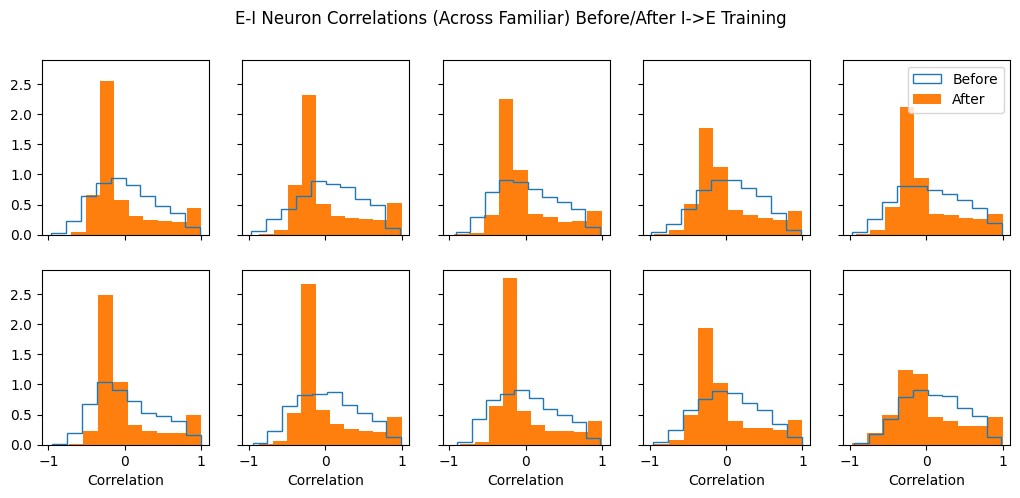

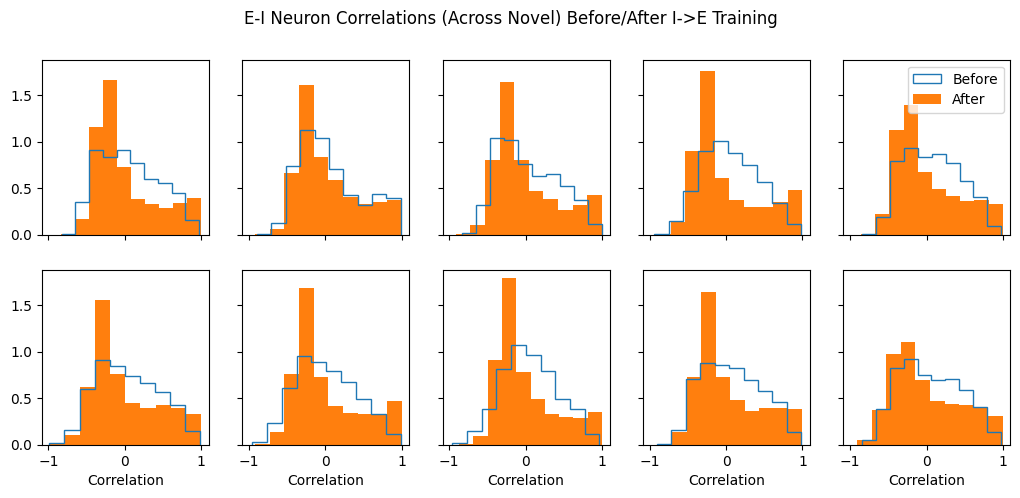

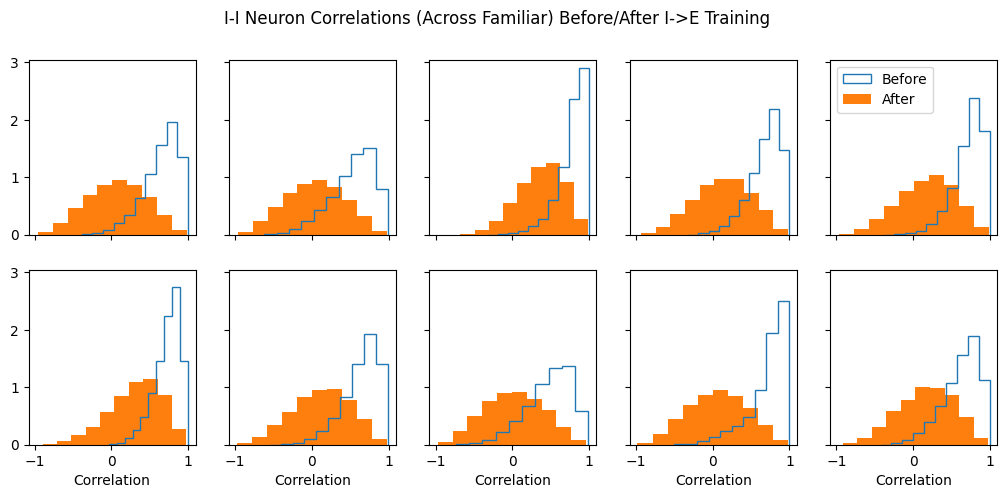

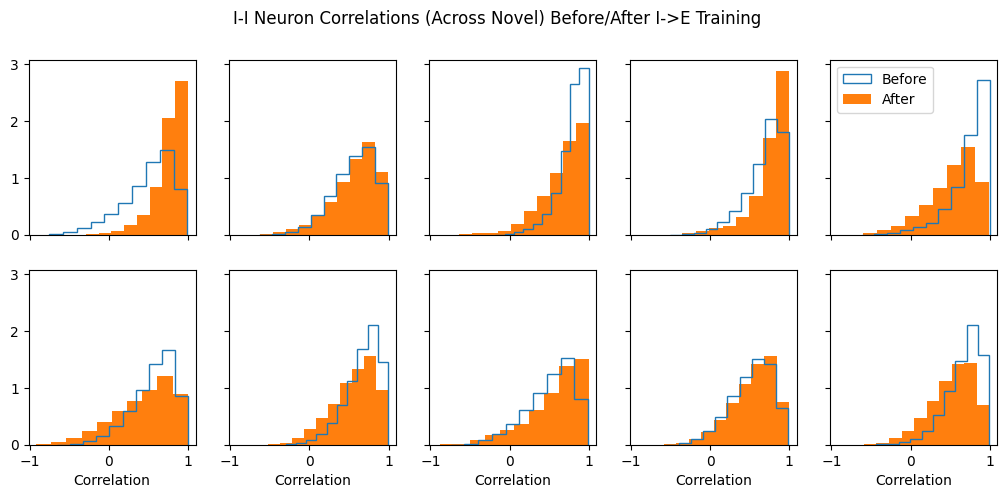

In [25]:
# generate_corr_hist("./sp_reg/ie", (num_e, num_neurons), (0, num_e), familiar_inds)
# plt.suptitle("E-I Neuron Correlations (Across Familiar) Before/After E->I Training")
# generate_corr_hist("./sp_reg/ie", (num_e, num_neurons), (0, num_e), novel_inds)
# plt.suptitle("E-I Neuron Correlations (Across Novel) Before/After E->I Training")
# plt.show()

# generate_corr_hist("./sp_reg/ie", (num_e, num_neurons), (num_e, num_neurons), familiar_inds)
# plt.suptitle("I-I Neuron Correlations (Across Familiar) Before/After E->I Training")
# generate_corr_hist("./sp_reg/ie", (num_e, num_neurons), (num_e, num_neurons), novel_inds)
# plt.suptitle("I-I Neuron Correlations (Across Novel) Before/After E->I Training")
# plt.show()

generate_corr_hist("./sp_reg/ie", (num_e, num_neurons), (0, num_e), familiar_inds)
plt.suptitle("E-I Neuron Correlations (Across Familiar) Before/After I->E Training")
generate_corr_hist("./sp_reg/ie", (num_e, num_neurons), (0, num_e), novel_inds)
plt.suptitle("E-I Neuron Correlations (Across Novel) Before/After I->E Training")
plt.show()

generate_corr_hist("./sp_reg/ei", (num_e, num_neurons), (num_e, num_neurons), familiar_inds)
plt.suptitle("I-I Neuron Correlations (Across Familiar) Before/After I->E Training")
generate_corr_hist("./sp_reg/ei", (num_e, num_neurons), (num_e, num_neurons), novel_inds)
plt.suptitle("I-I Neuron Correlations (Across Novel) Before/After I->E Training")
plt.show()

In [26]:
def generate_weights_hist(path, post, pre):
    sz = 2.5
    rows, cols = 2, 5
    fig = plt.figure(figsize=(cols*sz, rows*sz))
    ax = fig.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    for r in range(rows*cols):
        x, y = r // cols, r % cols

        W_initial = torch.load(f"{path}/realization_{r}/data/W_initial.pt").detach().cpu()
        W_trained = torch.load(f"{path}/realization_{r}/data/W_trained.pt").detach().cpu()
        
        inds = get_update_inds(post, pre, W_initial)
        W0 = W_initial[inds]
        Wf = W_trained[inds]

        #print(f"{torch.count_nonzero(torch.logical_and(torch.abs(Wf) < 0.15, torch.abs(Wf) > 1e-2))} out of {len(inds[0])}")
        #print(f"{torch.count_nonzero(Wf == 0.)} out of {len(inds[0])}")

        ax[x, y].hist(W0.flatten(), label="Before", histtype="step")
        ax[x, y].hist(Wf.flatten(), label="After")
        ax[x, y].set_yscale("log")
        if x == rows - 1:
            ax[x, y].set_xlabel("Weight")
        if (x, y) == (0, cols - 1):
            ax[x, y].legend()

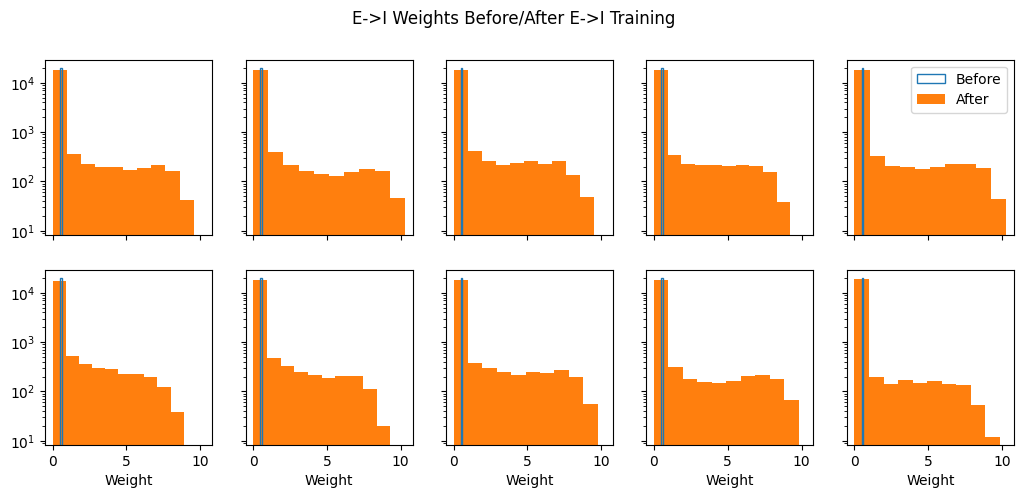

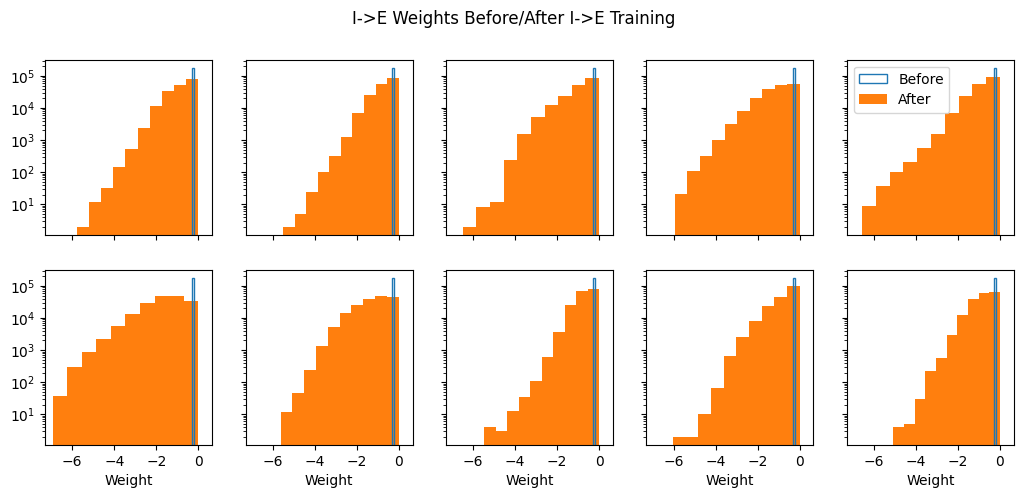

In [27]:
# generate_weights_hist("./standard/ie", (num_e, num_neurons), (0, num_e))
# plt.suptitle("E->I Weights Before/After E->I Training")
# plt.show()

generate_weights_hist("./sp_reg/ie", (num_e, num_neurons), (0, num_e))
plt.suptitle("E->I Weights Before/After E->I Training")
plt.show()

generate_weights_hist("./sp_reg/ei", (0, num_e), (num_e, num_neurons))
plt.suptitle("I->E Weights Before/After I->E Training")
plt.show()

# E->I: To reduce correlations without increasing sparsity, it's convenient to sparsify the connectivity (setting weights to 0)
# I->E: Less weights set to 0

### Distribution of Zero Weights Across Postsynaptic Neurons

In [28]:
def weights_dist(path, post, pre, is_presyn=0):
    sz = 2.5
    rows, cols = 2, 5
    fig = plt.figure(figsize=(cols*sz, rows*sz))
    ax = fig.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    for r in range(rows*cols):
        x, y = r // cols, r % cols

        W_initial = torch.load(f"{path}/realization_{r}/data/W_initial.pt").detach().cpu()
        W_trained = torch.load(f"{path}/realization_{r}/data/W_trained.pt").detach().cpu()

        W0 = W_initial[post[0]:post[1], pre[0]:pre[1]]
        Wf = W_trained[post[0]:post[1], pre[0]:pre[1]]

        # Look at the indices that became nonzero after training
        # Postsynaptic indices: index 0, presyn: index 1
        inds = torch.nonzero(torch.logical_and(W0 != 0, Wf == 0), as_tuple=True)[is_presyn]
        counts = torch.sort(torch.unique(inds, return_counts=True)[1]).values

        ax[x, y].bar(torch.arange(len(counts)), counts)
        #ax[x, y].set_yscale("log")
        if x == rows - 1:
            ax[x, y].set_xlabel("Neuron")
        # if (x, y) == (0, cols - 1):
        #     ax[x, y].legend()

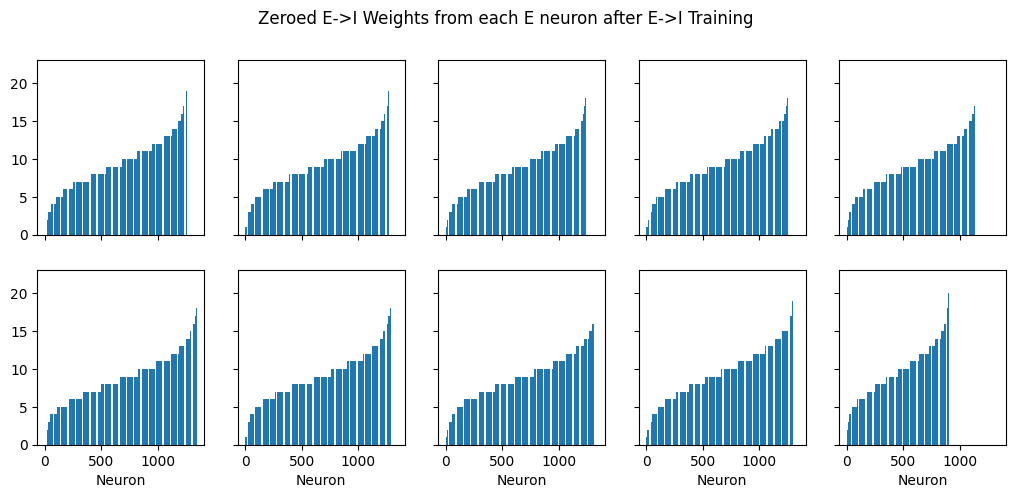

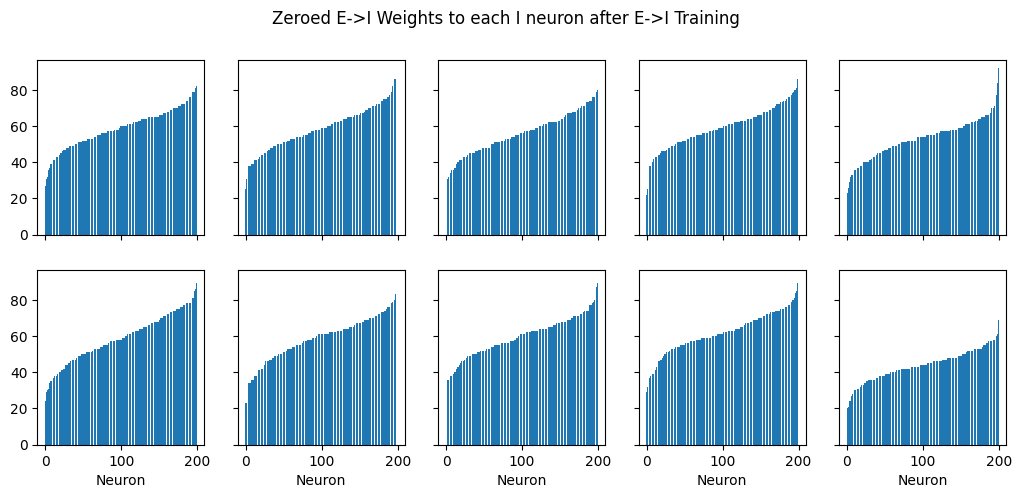

In [29]:
weights_dist("./sp_reg/ie", (num_e, num_neurons), (0, num_e), is_presyn=1)
plt.suptitle("Zeroed E->I Weights from each E neuron after E->I Training")
plt.show()

weights_dist("./sp_reg/ie", (num_e, num_neurons), (0, num_e), is_presyn=0)
plt.suptitle("Zeroed E->I Weights to each I neuron after E->I Training")
plt.show()

# weights_dist("./sp_reg/ei", (0, num_e), (num_e, num_neurons))
# plt.suptitle("Zeroed I->E Weights to each E neuron after I->E Training")
# plt.show()

# E->I: Seems pretty uniformly distributed across I neurons - no selective sparsification
# I->E: 

### Lifetime Sparsity Across Odor Families

In [30]:
# "Lifetime sparsity" (1 - coding level) - for each neuron, how many odors in an odor family does it respond to
def lifetime_sparsity(R, odor_inds):
    lifetime_sparsity = 1 - (torch.count_nonzero(R[:num_e, odor_inds], dim=1) / (P // 2))
    return lifetime_sparsity


def lifetime_sparsity_hist(path, odor_family):
    sz = 2.5
    rows, cols = 2, 5
    fig = plt.figure(figsize=(cols*sz, rows*sz))
    ax = fig.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    for r in range(rows*cols):
        x, y = r // cols, r % cols

        R_initial = torch.load(f"{path}/realization_{r}/data/R_initial.pt").detach().cpu()
        R_trained = torch.load(f"{path}/realization_{r}/data/R_trained.pt").detach().cpu()
        
        sp0 = lifetime_sparsity(R_initial.detach().cpu(), odor_family)
        mu0 = torch.mean(sp0)
        spf = lifetime_sparsity(R_trained.detach().cpu(), odor_family)
        muf = torch.mean(spf)

        bins = torch.histogram(torch.cat((sp0, spf)), bins=8)
        ax[x, y].hist(sp0, label="Before", bins=bins.bin_edges, density=True, histtype="step")
        ax[x, y].hist(spf, label="After", bins=bins.bin_edges, density=True)
        ax[x, y].axvline(mu0, color="tab:blue")
        ax[x, y].axvline(muf, color="tab:orange")
        if x == rows - 1:
            ax[x, y].set_xlabel("Sparsity")
        if (x, y) == (0, cols - 1):
            ax[x, y].legend()

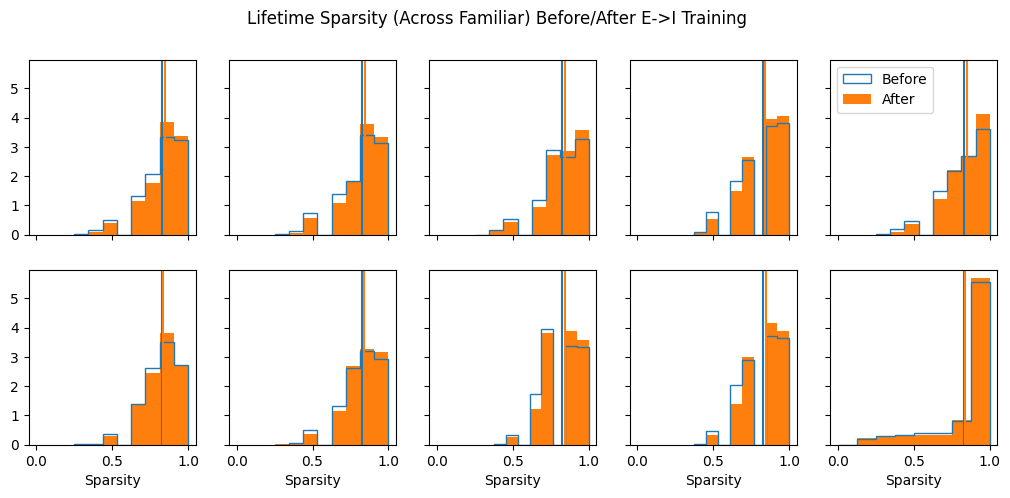

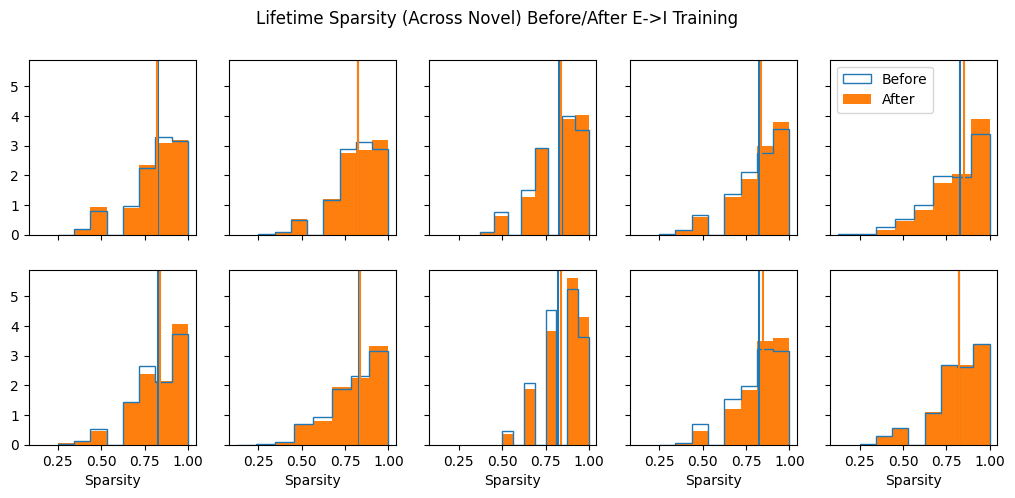

Text(0.5, 0.98, 'Lifetime Sparsity (Across Novel) Before/After I->E Training')

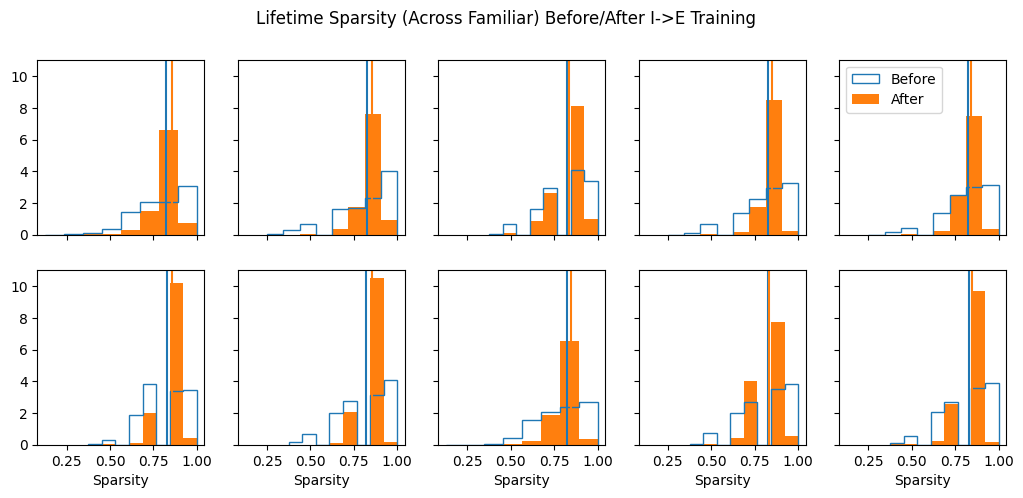

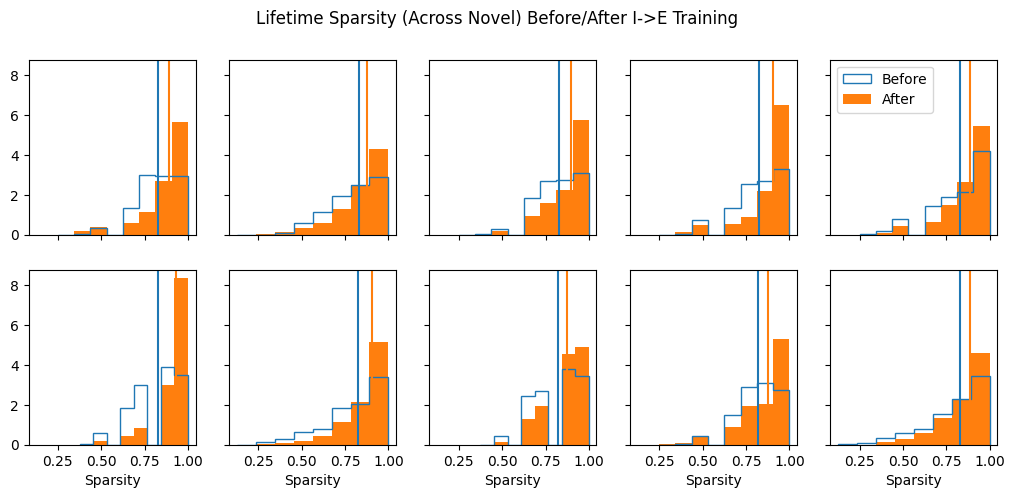

In [31]:
lifetime_sparsity_hist("./sp_reg/ie", familiar_inds)
plt.suptitle("Lifetime Sparsity (Across Familiar) Before/After E->I Training")

lifetime_sparsity_hist("./sp_reg/ie", novel_inds)
plt.suptitle("Lifetime Sparsity (Across Novel) Before/After E->I Training")
plt.show()

lifetime_sparsity_hist("./sp_reg/ei", familiar_inds)
plt.suptitle("Lifetime Sparsity (Across Familiar) Before/After I->E Training")

lifetime_sparsity_hist("./sp_reg/ei", novel_inds)
plt.suptitle("Lifetime Sparsity (Across Novel) Before/After I->E Training")

# lifetime_sparsity("./sp_reg/ei", familiar_inds)
# plt.suptitle("E-E Neuron Correlations (Across Familiar) Before/After I->E Training")

In [32]:
# How many inputs each pair of I neurons share (there's a shared input if there's a nonzero weight)
def i_input_sharing(W, pair_inds):
    comp = (W[num_e:, :num_e] > 0)[pair_inds]
    pair_shares = torch.sum((comp[:, 0, :] & comp[:, 1, :]), dim=1)
    return pair_shares

In [56]:
def corr_diff_for_sharing_plot(path):
    sz = 2.5
    rows, cols = 2, 5
    fig = plt.figure(figsize=(cols*sz, rows*sz))
    ax = fig.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    pair_inds = torch.triu_indices(num_i, num_i, 1).t()

    for r in range(rows*cols):
        x, y = r // cols, r % cols

        R_initial = torch.load(f"{path}/realization_{r}/data/R_initial.pt").detach().cpu()
        W_initial = torch.load(f"{path}/realization_{r}/data/W_initial.pt").detach().cpu()
        R_trained = torch.load(f"{path}/realization_{r}/data/R_trained.pt").detach().cpu()
        W_trained = torch.load(f"{path}/realization_{r}/data/W_trained.pt").detach().cpu()
        
        share0 = i_input_sharing(W_initial, pair_inds)
        corrs0 = neuron_corrs(R_initial, familiar_inds)[num_e:, num_e:][pair_inds[:, 0], pair_inds[:, 1]]
        sharef = i_input_sharing(W_trained, pair_inds)
        corrsf = neuron_corrs(R_trained, familiar_inds)[num_e:, num_e:][pair_inds[:, 0], pair_inds[:, 1]]
        share_diff = sharef - share0
        corrs_diff = corrsf - corrs0

        runs = 100
        s_r = torch.empty((runs,))
        for i in range(runs):
            shuffled_corrs = corrs_diff[torch.randperm(pair_inds.shape[0])]
            shuffled_pairs = share_diff[torch.randperm(pair_inds.shape[0])]
            shuffled_R = torch.corrcoef(torch.vstack((shuffled_pairs, shuffled_corrs)))[0, 1]
            s_r[i] = shuffled_R
        
        data_R = torch.corrcoef(torch.vstack((share_diff, corrs_diff)))[0, 1]
        tail = torch.count_nonzero(s_r > data_R) / runs
        print(f"P-value: {tail}")
        print(f"R-value: {data_R}")

        # Don't plot if two I didn't share inputs initially (because they won't after training)
        has_shared = share0 > 0

        ax[x, y].scatter(share_diff[has_shared], corrs_diff[has_shared], s=1, alpha=0.5)
        #ax[x, y].scatter(x_range, sharef, label="After")
        if x == rows - 1:
            ax[x, y].set_xlabel("E Shared final - initial")
        if y == 0:
            ax[x, y].set_ylabel("I-I Corr final - initial")
        # if (x, y) == (0, cols - 1):
        #     ax[x, y].legend()

In [59]:
def corr_for_sharing_plot(path):
    sz = 2.5
    rows, cols = 2, 5
    fig = plt.figure(figsize=(cols*sz, rows*sz))
    ax = fig.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    pair_inds = torch.triu_indices(num_i, num_i, 1).t()

    for r in range(rows*cols):
        x, y = r // cols, r % cols

        R_initial = torch.load(f"{path}/realization_{r}/data/R_initial.pt").detach().cpu()
        W_initial = torch.load(f"{path}/realization_{r}/data/W_initial.pt").detach().cpu()
        R_trained = torch.load(f"{path}/realization_{r}/data/R_trained.pt").detach().cpu()
        W_trained = torch.load(f"{path}/realization_{r}/data/W_trained.pt").detach().cpu()
        
        share0 = i_input_sharing(W_initial, pair_inds)
        #corrs0 = neuron_corrs(R_initial, familiar_inds)[num_e:, num_e:][pair_inds[:, 0], pair_inds[:, 1]]
        sharef = i_input_sharing(W_trained, pair_inds)
        corrsf = neuron_corrs(R_trained, familiar_inds)[num_e:, num_e:][pair_inds[:, 0], pair_inds[:, 1]]
        share_diff = sharef
        corrs_diff = corrsf

        runs = 100
        s_r = torch.empty((runs,))
        for i in range(runs):
            shuffled_corrs = corrs_diff[torch.randperm(pair_inds.shape[0])]
            shuffled_pairs = share_diff[torch.randperm(pair_inds.shape[0])]
            shuffled_R = torch.corrcoef(torch.vstack((shuffled_pairs, shuffled_corrs)))[0, 1]
            s_r[i] = shuffled_R
        
        data_R = torch.corrcoef(torch.vstack((share_diff, corrs_diff)))[0, 1]
        tail = torch.count_nonzero(s_r > data_R) / runs
        print(f"P-value: {tail}")
        print(f"R-value: {data_R}")

        # Don't plot if two I didn't share inputs initially (because they won't after training)
        has_shared = share0 > 0

        ax[x, y].scatter(share_diff[has_shared], corrs_diff[has_shared], s=1, alpha=0.5)
        #ax[x, y].scatter(x_range, sharef, label="After")
        if x == rows - 1:
            ax[x, y].set_xlabel("E Shared")
        if y == 0:
            ax[x, y].set_ylabel("I-I Corr")
        # if (x, y) == (0, cols - 1):
        #     ax[x, y].legend()

P-value: 0.0
R-value: 0.07492773234844208
P-value: 0.0
R-value: 0.06354063004255295
P-value: 0.0
R-value: 0.061566416174173355
P-value: 0.0
R-value: 0.08146972954273224
P-value: 0.0
R-value: 0.0772828683257103
P-value: 0.0
R-value: 0.10072077810764313
P-value: 0.0
R-value: 0.051333192735910416
P-value: 0.0
R-value: 0.09745565801858902
P-value: 0.0
R-value: 0.06488525122404099
P-value: 0.0
R-value: 0.08829670399427414
P-value: 0.0
R-value: 0.06887699663639069
P-value: 0.0
R-value: 0.07283967733383179
P-value: 0.0
R-value: 0.07158903032541275
P-value: 0.0
R-value: 0.06851604580879211
P-value: 0.0
R-value: 0.04246680438518524
P-value: 0.0
R-value: 0.09404116868972778
P-value: 0.0
R-value: 0.07221684604883194
P-value: 0.0
R-value: 0.06790388375520706
P-value: 0.0
R-value: 0.05989740416407585
P-value: 0.0
R-value: 0.04369174689054489


Text(0.5, 0.98, 'E->I (After Training): Number of shared inputs to I neurons vs Correlation')

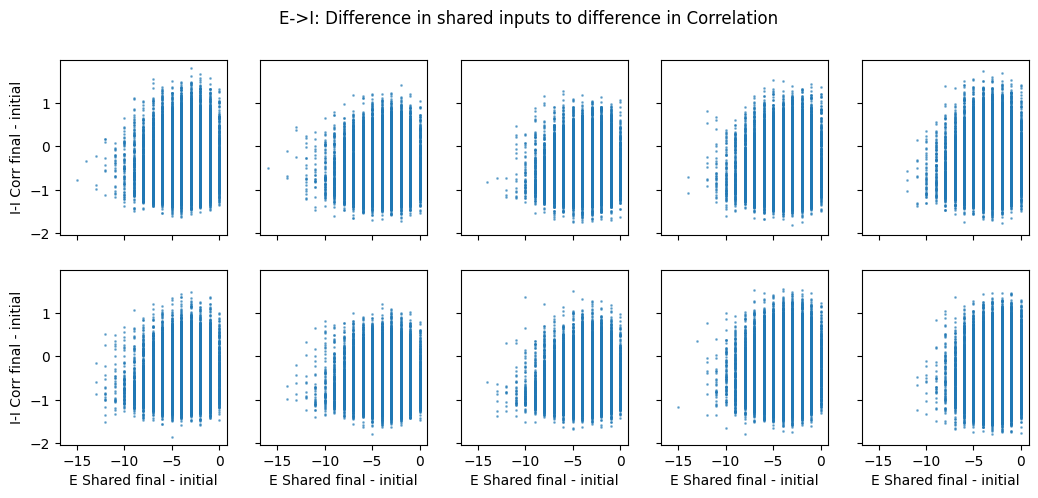

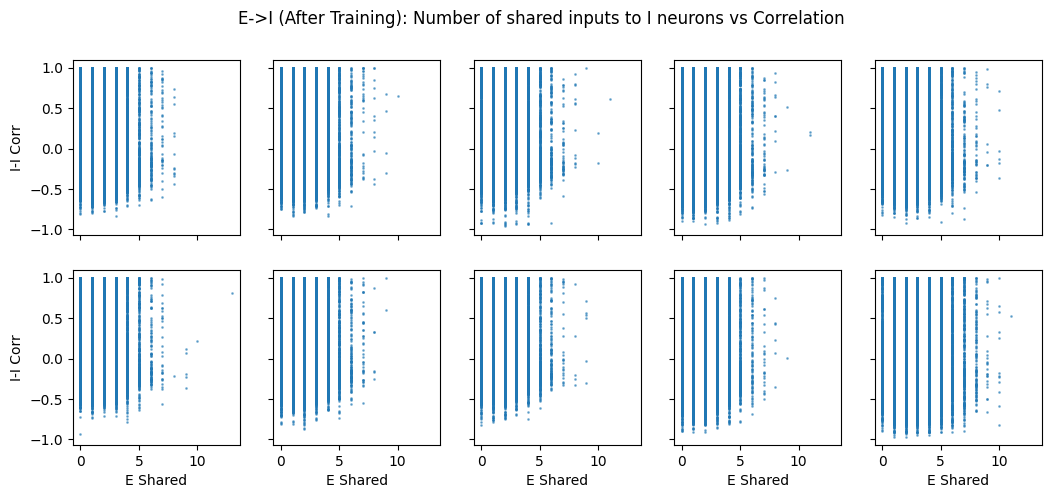

In [60]:
# Sorted in order of difference before/after training
corr_diff_for_sharing_plot("./sp_reg/ie")
plt.suptitle("E->I: Difference in shared inputs to difference in Correlation")

corr_for_sharing_plot("./sp_reg/ie")
plt.suptitle("E->I (After Training): Number of shared inputs to I neurons vs Correlation")

In [ ]:
# Null model: shuffled inds of x and y (shouldn't be any shape to the data)
# Run 100 times and compute R (correlation coefficient)
# Compare it to the R of the data, see whether the effect of the data is statistically significant
# P-value of 0: since we have 100 random-shuffle runs, means that less than 1% (none of the runs) had a higher R value than the data
# - means that the data is truly statistically significant in the linear correlation between lack of common inputs and anti-correlation 

# For the difference plot, we see that if I neurons lose a lot of common inputs, they become anti-correlated
# (but we still see that for neurons which don't lose many common inputs, they could either stay correlated or lose correlation)

# For the absolute plot, we see that if I neurons don't share many common inputs after training, they are less likely to be correlated

tensor(346)
tensor(1957959)
tensor([ 1.0000, -0.1798, -0.1798,  ...,     nan,     nan,     nan])


RuntimeError: torch.histogramdd: dimension 0's range [-nan, -nan] is not finite

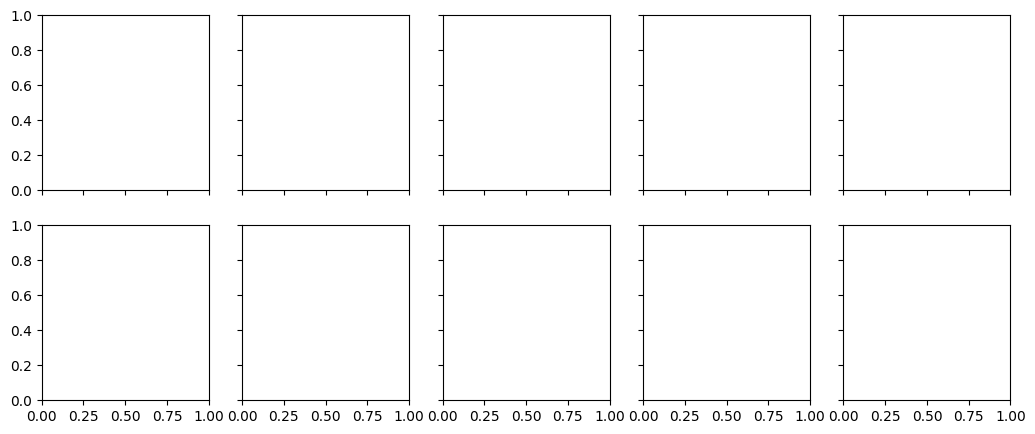

In [73]:
sz = 2.5
rows, cols = 2, 5
fig = plt.figure(figsize=(cols*sz, rows*sz))
ax = fig.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
path = "./sp_reg/ie"
for r in range(rows*cols):
    x, y = r // cols, r % cols

    R_trained = torch.load(f"{path}/realization_{r}/data/R_trained.pt").detach().cpu()
    print(torch.sum(torch.sum(R_trained != 0, dim=1) == 0))
    W_trained = torch.load(f"{path}/realization_{r}/data/W_trained.pt").detach().cpu()

    trained_corrs = neuron_corrs(R_trained, familiar_inds)
    print(torch.count_nonzero(torch.isnan(trained_corrs)))
    corrs_connected = trained_corrs[torch.nonzero(W_trained[num_e:, :num_e] != 0, as_tuple=True)]
    corrs_unconnected = trained_corrs[torch.nonzero(W_trained[num_e:, :num_e] == 0, as_tuple=True)]
    print(corrs_unconnected)

    bins = torch.histogram(torch.cat((corrs_connected, corrs_unconnected)), bins=10)
    ax[x, y].hist(corrs_connected, label="Connected", density=True, bins=bins)
    ax[x, y].hist(corrs_unconnected, label="Unconnected", density=True, bins=bins)
    if x == rows - 1:
        ax[x, y].set_xlabel("Correlation")
    if (x, y) == (0, cols - 1):
        ax[x, y].legend()

plt.suptitle("E-I correlations After Training for Connected vs Unconnected Neurons")
plt.show()

# sz = 2.5
# rows, cols = 2, 5
# fig = plt.figure(figsize=(cols*sz, rows*sz))
# ax = fig.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
# path = "./sp_reg/ie"
# for r in range(rows*cols):
#     x, y = r // cols, r % cols

#     R_trained = torch.load(f"{path}/realization_{r}/data/R_trained.pt").detach().cpu()
#     W_trained = torch.load(f"{path}/realization_{r}/data/W_trained.pt").detach().cpu()

    

#     bins = 10
    
#     if x == rows - 1:
#         ax[x, y].set_xlabel("Correlation")
#     # if (x, y) == (0, cols - 1):
#     #     ax[x, y].legend()

# plt.suptitle("E-I correlations After Training for Unconnected Neurons")
# plt.show()

### Odor Correlation <> Weight Values

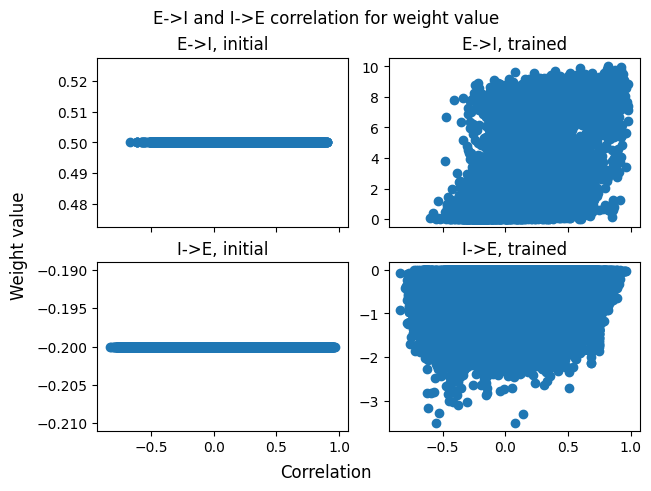

In [ ]:
# sp_realization_num = 2

# fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, constrained_layout=True)

# # IE

# ie_initial_corrs = torch.corrcoef(R_ie_initial)[ie_update_inds]
# ie_initial_corrs, inds = torch.sort(ie_initial_corrs)
# ax[0, 0].scatter(ie_initial_corrs, W_ie_initial[ie_update_inds][inds])
# ax[0, 0].set_title("E->I, initial")
# ie_final_corrs = torch.corrcoef(R_ie_trained)[ie_update_inds]
# ie_final_corrs, inds = torch.sort(ie_final_corrs)
# ax[0, 1].scatter(ie_final_corrs, W_ie_trained[ie_update_inds][inds])
# ax[0, 1].set_title("E->I, trained")

# # EI

# ei_initial_corrs = torch.corrcoef(R_initial)[ei_update_inds]
# ei_initial_corrs, inds = torch.sort(ei_initial_corrs)
# ax[1, 0].scatter(ei_initial_corrs, W_ei_initial[ei_update_inds][inds])
# ax[1, 0].set_title("I->E, initial")
# ei_final_corrs = torch.corrcoef(R_trained)[ei_update_inds]
# ei_final_corrs, inds = torch.sort(ei_final_corrs)
# ax[1, 1].scatter(ei_final_corrs, W_ei_trained[ei_update_inds][inds])
# ax[1, 1].set_title("I->E, trained")

# fig.supxlabel("Correlation")
# fig.supylabel("Weight value")
# fig.suptitle("E->I and I->E correlation for weight value")

# plt.show()